# Project Title: Predicting Heart Disease

## Problem Statement

Your goal is to predict the binary class heart_disease_present, which represents whether or not a patient has heart disease:   
   
0 represents no heart disease present   
1 represents heart disease present   

## Data Set Description

There are 14 columns in the dataset, where the patient_id column is a unique and random identifier. The remaining 13 features are described in the section below.   
   
slope_of_peak_exercise_st_segment (type: int): the slope of the peak exercise ST segment, an electrocardiography read out indicating quality of blood flow to the heart   
thal (type: categorical): results of thallium stress test measuring blood flow to the heart, with possible values normal, fixed_defect, reversible_defect   
resting_blood_pressure (type: int): resting blood pressure   
chest_pain_type (type: int): chest pain type (4 values)   
num_major_vessels (type: int): number of major vessels (0-3) colored by flourosopy   
fasting_blood_sugar_gt_120_mg_per_dl (type: binary): fasting blood sugar > 120 mg/dl   
resting_ekg_results (type: int): resting electrocardiographic results (values 0,1,2)   
serum_cholesterol_mg_per_dl (type: int): serum cholestoral in mg/dl   
oldpeak_eq_st_depression (type: float): oldpeak = ST depression induced by exercise relative to rest, a measure of abnormality in electrocardiograms   
sex (type: binary): 0: female, 1: male   
age (type: int): age in years   
max_heart_rate_achieved (type: int): maximum heart rate achieved (beats per minute)   
exercise_induced_angina (type: binary): exercise-induced chest pain (0: False, 1: True)   

## Evaluation Metric

This competition uses log loss as its evaluation metric, so the heart_disease_present values you should submit are the probabilities that a patient has heart disease (not the binary label).

## 1. Import Libraries

In [1322]:
# data manipulation and descriptive statistics
import pandas as pd
import numpy as np
import warnings
import missingno
from scipy.stats import kurtosis
from scipy.stats import skew
import random as rnd
import os
import re
import itertools 

# visualization
from matplotlib import pyplot as plt
import seaborn as sns
get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (15, 8)
import scikitplot as skplt

# supervised
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn import feature_selection
from xgboost import XGBClassifier
import xgboost as xgb
import hyperopt # CatBoost
from catboost import Pool, CatBoostClassifier # CatBoost
import lightgbm as lgb # Light GBM
import statsmodels.api as sm # Logistic Regression with StatModels

# unsupervised
from sklearn.decomposition import PCA

# evaluation metric
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score

# grid
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# Ensemble Voting
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

# Stacking
from matplotlib.colors import ListedColormap

# Warnings
import warnings
warnings.filterwarnings(action="ignore")

%matplotlib inline

# Time
import time
import datetime
import platform
start = time.time()

# changing the display settings
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', -1)  

In [1323]:
# initialise general parameters
n_splits = 5 # cv split
n_iter = 50 
scoring = "accuracy"
rstate = 101
testset_size = 0.2

# boosting rounds
num_rounds = 800

# trees parameters
n_tree_range = st.randint(100, num_rounds)

## 2. Import Data

In [1324]:
train = pd.read_csv("C:\\Users\\joann\\OneDrive\\Desktop\\My Files\\Data Science\\Predicting Heart Disease\\train_values.csv")

In [1325]:
train_labels = pd.read_csv("C:\\Users\\joann\\OneDrive\\Desktop\\My Files\\Data Science\\Predicting Heart Disease\\train_labels.csv")

In [1326]:
test = pd.read_csv("C:\\Users\\joann\\OneDrive\\Desktop\\My Files\\Data Science\\Predicting Heart Disease\\test_values.csv")

In [1327]:
# combine train and train_labels
full_train = pd.merge(train, train_labels, how="left", on="patient_id")

## 3. Data Preprocessing

### Overview of data

In [1328]:
train.shape

(180, 14)

In [1329]:
full_train.shape

(180, 15)

In [1330]:
full_train.columns

Index(['patient_id', 'slope_of_peak_exercise_st_segment', 'thal',
       'resting_blood_pressure', 'chest_pain_type', 'num_major_vessels',
       'fasting_blood_sugar_gt_120_mg_per_dl', 'resting_ekg_results',
       'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'sex', 'age',
       'max_heart_rate_achieved', 'exercise_induced_angina',
       'heart_disease_present'],
      dtype='object')

In [1331]:
test.shape

(90, 14)

In [1332]:
full_train.head(10)

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0
5,ldukkw,1,normal,130,3,0,0,0,180,0.0,1,42,150,0,0
6,2gbyh9,2,reversible_defect,150,4,2,0,2,258,2.6,0,60,157,0,1
7,daa9kp,2,fixed_defect,150,4,1,0,2,276,0.6,1,57,112,1,1
8,3nwy2n,3,reversible_defect,170,4,0,0,2,326,3.4,1,59,140,1,1
9,1r508r,2,normal,120,3,0,0,0,219,1.6,0,50,158,0,0


In [1333]:
full_train.dtypes

patient_id                              object 
slope_of_peak_exercise_st_segment       int64  
thal                                    object 
resting_blood_pressure                  int64  
chest_pain_type                         int64  
num_major_vessels                       int64  
fasting_blood_sugar_gt_120_mg_per_dl    int64  
resting_ekg_results                     int64  
serum_cholesterol_mg_per_dl             int64  
oldpeak_eq_st_depression                float64
sex                                     int64  
age                                     int64  
max_heart_rate_achieved                 int64  
exercise_induced_angina                 int64  
heart_disease_present                   int64  
dtype: object

In [1334]:
full_train.describe()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,1.550000,131.311111,3.155556,0.694444,0.161111,1.050000,249.211111,1.010000,0.688889,54.811111,149.483333,0.316667,0.444444
std,0.618838,17.010443,0.938454,0.969347,0.368659,0.998742,52.717969,1.121357,0.464239,9.334737,22.063513,0.466474,0.498290
min,1.000000,94.000000,1.000000,0.000000,0.000000,0.000000,126.000000,0.000000,0.000000,29.000000,96.000000,0.000000,0.000000
25%,1.000000,120.000000,3.000000,0.000000,0.000000,0.000000,213.750000,0.000000,0.000000,48.000000,132.000000,0.000000,0.000000
50%,1.000000,130.000000,3.000000,0.000000,0.000000,2.000000,245.500000,0.800000,1.000000,55.000000,152.000000,0.000000,0.000000
75%,2.000000,140.000000,4.000000,1.000000,0.000000,2.000000,281.250000,1.600000,1.000000,62.000000,166.250000,1.000000,1.000000
max,3.000000,180.000000,4.000000,3.000000,1.000000,2.000000,564.000000,6.200000,1.000000,77.000000,202.000000,1.000000,1.000000


### Convert Data Type

In [1335]:
full_train["slope_of_peak_exercise_st_segment"] = full_train["slope_of_peak_exercise_st_segment"].astype("object")
full_train["chest_pain_type"] = full_train["chest_pain_type"].astype("object")
full_train["fasting_blood_sugar_gt_120_mg_per_dl"] = full_train["fasting_blood_sugar_gt_120_mg_per_dl"].astype("object")
full_train["resting_ekg_results"] = full_train["resting_ekg_results"].astype("object")
full_train["sex"] = full_train["sex"].astype("object")
full_train["exercise_induced_angina"] = full_train["exercise_induced_angina"].astype("object")
full_train["heart_disease_present"] = full_train["heart_disease_present"].astype("object")

In [1336]:
full_train.dtypes

patient_id                              object 
slope_of_peak_exercise_st_segment       object 
thal                                    object 
resting_blood_pressure                  int64  
chest_pain_type                         object 
num_major_vessels                       int64  
fasting_blood_sugar_gt_120_mg_per_dl    object 
resting_ekg_results                     object 
serum_cholesterol_mg_per_dl             int64  
oldpeak_eq_st_depression                float64
sex                                     object 
age                                     int64  
max_heart_rate_achieved                 int64  
exercise_induced_angina                 object 
heart_disease_present                   object 
dtype: object

### Missing Values

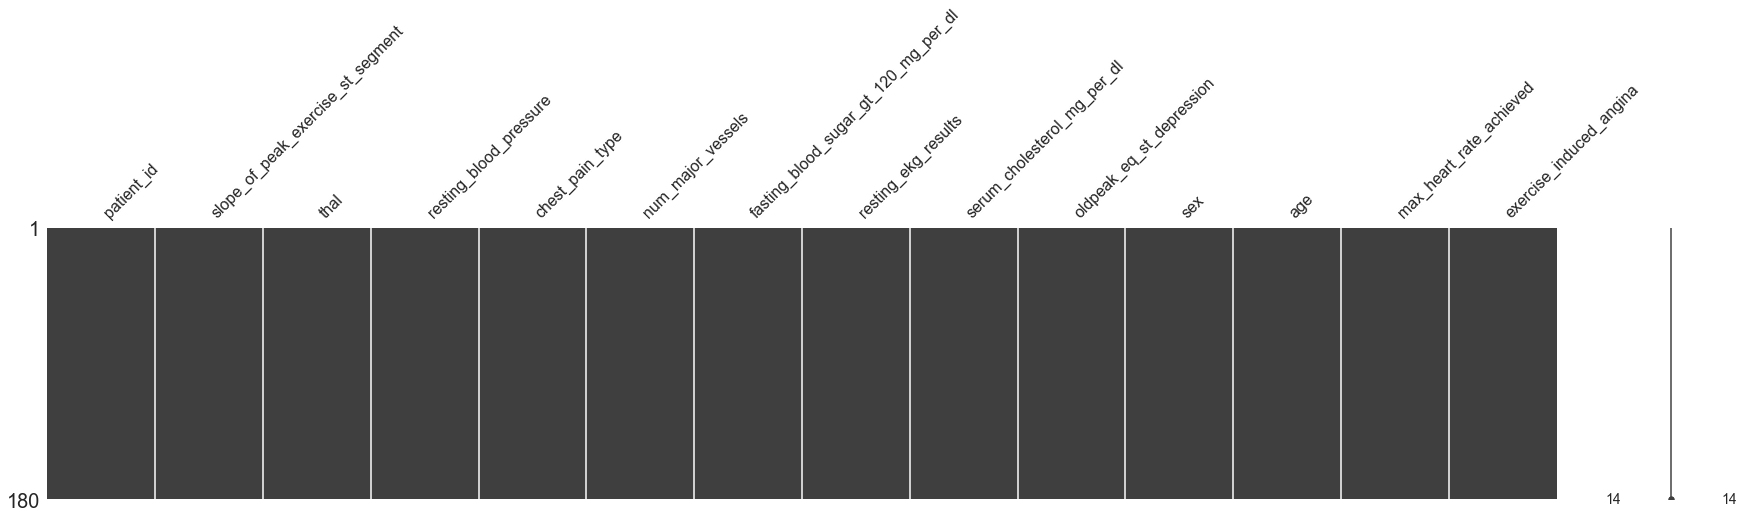

In [1337]:
missingno.matrix(train, figsize = (30,5))

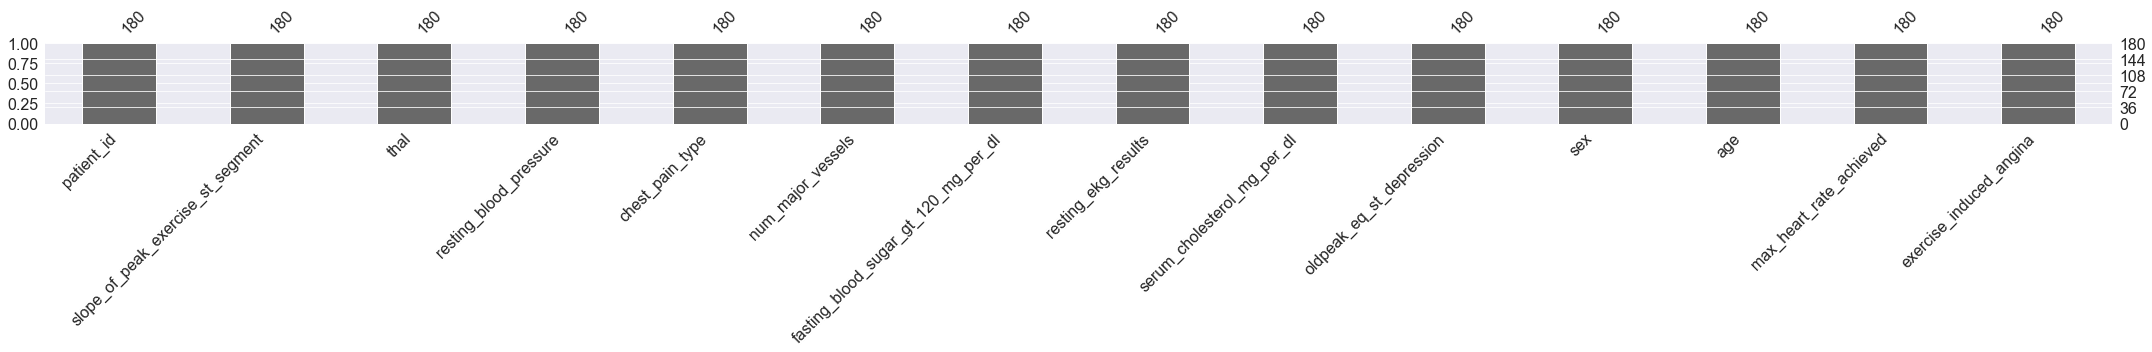

In [1338]:
missingno.bar(train, sort='ascending', figsize = (30,5))

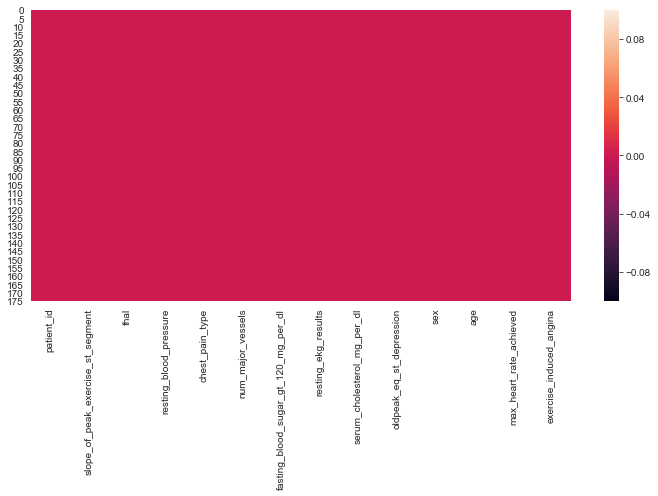

In [1339]:
plt.figure(figsize=(10,7))
sns.heatmap(train.isnull())

There are no missing values in the dataset!

## 4. Exploratory Data Analysis

### Feature: slope_of_peak_exercise_st_segment

The slope of the peak exercise ST segment, an electrocardiography read out indicating quality of blood flow to the heart   

In [1340]:
full_train["slope_of_peak_exercise_st_segment"].value_counts()

1    93
2    75
3    12
Name: slope_of_peak_exercise_st_segment, dtype: int64

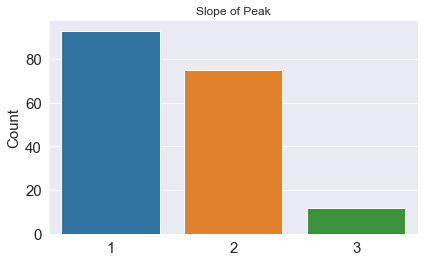

In [1341]:
sns.set_style("darkgrid")
b = sns.countplot(x="slope_of_peak_exercise_st_segment", data=full_train)
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("Slope of Peak")
plt.ylabel("Count")
plt.xlabel(" ")
plt.show()

In [1342]:
# how does the slope affect the presence of heart disease?
p1 = pd.crosstab(full_train["slope_of_peak_exercise_st_segment"], full_train["heart_disease_present"])

In [1343]:
p1

heart_disease_present,0,1
slope_of_peak_exercise_st_segment,,
1,68,25
2,28,47
3,4,8


In [1344]:
slope_1_heart_0 = p1[0][1]/(p1[0][1] + p1[1][1])*100
slope_1_heart_1 = p1[1][1]/(p1[0][1] + p1[1][1])*100
slope_2_heart_0 = p1[0][2]/(p1[0][2] + p1[1][2])*100
slope_2_heart_1 = p1[1][2]/(p1[0][2] + p1[1][2])*100
slope_3_heart_0 = p1[0][3]/(p1[0][3] + p1[1][3])*100
slope_3_heart_1 = p1[1][3]/(p1[0][3] + p1[1][3])*100

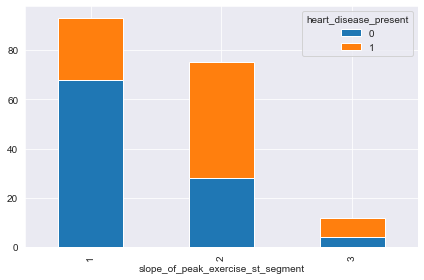

In [1345]:
p1.plot.bar(stacked=True)

In [1346]:
print("Percentage of patients with slope of peak 1 and no heart disease present {}".format(slope_1_heart_0))
print("Percentage of patients with slope of peak 1 and heart disease present {}".format(slope_1_heart_1))
print("Percentage of patients with slope of peak 2 and no heart disease present {}".format(slope_2_heart_0))
print("Percentage of patients with slope of peak 2 and heart disease present {}".format(slope_2_heart_1))
print("Percentage of patients with slope of peak 3 and no heart disease present {}".format(slope_3_heart_0))
print("Percentage of patients with slope of peak 3 and heart disease present {}".format(slope_3_heart_1))

Percentage of patients with slope of peak 1 and no heart disease present 73.11827956989248
Percentage of patients with slope of peak 1 and heart disease present 26.881720430107524
Percentage of patients with slope of peak 2 and no heart disease present 37.333333333333336
Percentage of patients with slope of peak 2 and heart disease present 62.66666666666667
Percentage of patients with slope of peak 3 and no heart disease present 33.33333333333333
Percentage of patients with slope of peak 3 and heart disease present 66.66666666666666


As the slope of peak increases, chances of heart disease present also increases

In [1347]:
full_train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


### Feature: thal

Results of thallium stress test measuring blood flow to the heart, with possible values normal, fixed_defect, reversible_defect

In [1348]:
full_train["thal"].value_counts()

normal               98
reversible_defect    74
fixed_defect         8 
Name: thal, dtype: int64

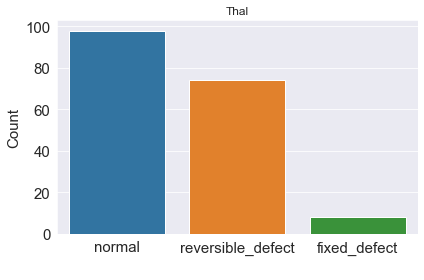

In [1349]:
sns.set_style("darkgrid")
b = sns.countplot(x="thal", data=full_train)
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("Thal")
plt.ylabel("Count")
plt.xlabel(" ")
plt.show()

In [1350]:
# how does thal level affect the presence of heart disease?
p2 = pd.crosstab(full_train["thal"], full_train["heart_disease_present"])

In [1351]:
p2

heart_disease_present,0,1
thal,,
fixed_defect,4,4
normal,78,20
reversible_defect,18,56


In [1352]:
thal_fixed_heart_0 = p2[0]["fixed_defect"]/(p2[0]["fixed_defect"] + p2[1]["fixed_defect"])
thal_fixed_heart_1 = p2[1]["fixed_defect"]/(p2[0]["fixed_defect"] + p2[1]["fixed_defect"])
thal_normal_heart_0 = p2[0]["normal"]/(p2[0]["normal"] + p2[1]["normal"])
thal_normal_heart_1 = p2[1]["normal"]/(p2[0]["normal"] + p2[1]["normal"])
thal_reversible_heart_0 = p2[0]["reversible_defect"]/(p2[0]["reversible_defect"] + p2[1]["reversible_defect"])
thal_reversible_heart_1 = p2[1]["reversible_defect"]/(p2[0]["reversible_defect"] + p2[1]["reversible_defect"])

<Figure size 1332x756 with 0 Axes>

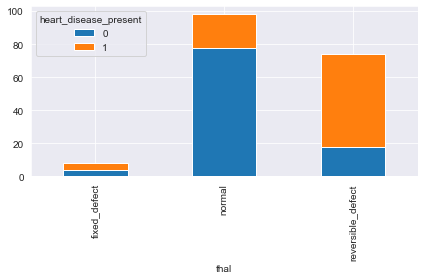

In [1353]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
p2.plot.bar(stacked=True)

In [1354]:
print("Percentage of patients with fixed defect thal and no heart disease present {}".format(thal_fixed_heart_0))
print("Percentage of patients with fixed defect thal and heart disease present {}".format(thal_fixed_heart_1))
print("Percentage of patients with normal thal and no heart disease present {}".format(thal_normal_heart_0))
print("Percentage of patients with normal thal and heart disease present {}".format(thal_normal_heart_1))
print("Percentage of patients with reversible defect and no heart disease present {}".format(thal_reversible_heart_0))
print("Percentage of patients with reversible defect and heart disease present {}".format(thal_reversible_heart_1))

Percentage of patients with fixed defect thal and no heart disease present 0.5
Percentage of patients with fixed defect thal and heart disease present 0.5
Percentage of patients with normal thal and no heart disease present 0.7959183673469388
Percentage of patients with normal thal and heart disease present 0.20408163265306123
Percentage of patients with reversible defect and no heart disease present 0.24324324324324326
Percentage of patients with reversible defect and heart disease present 0.7567567567567568


Patients with normal thal are more likely to have no heart disease while patients with reversible defect are more likely to have heart disease present

### Feature: resting_blood_pressure

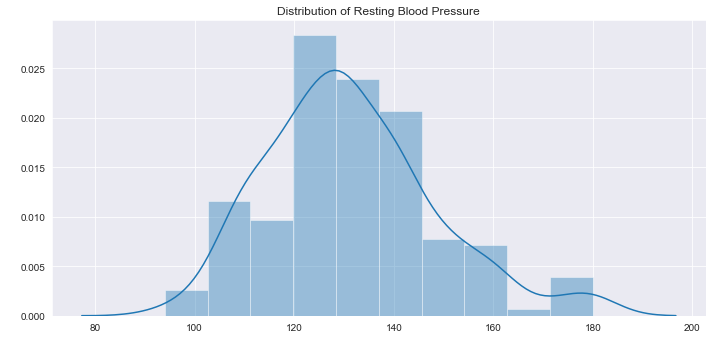

In [1355]:
# what is the distribution?
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
p3 = sns.distplot(full_train["resting_blood_pressure"],kde=True,bins=10)
b.axes.set_title("Title",fontsize=30)
b.set_xlabel("X Label",fontsize=20)
b.set_ylabel("Y Label",fontsize=20)
b.tick_params(labelsize=15)
plt.title("Distribution of Resting Blood Pressure")
plt.ylabel(" ")
plt.xlabel(" ")
plt.show()

In [1356]:
# descriptive statistics
print(full_train["resting_blood_pressure"].describe())

count    180.000000
mean     131.311111
std      17.010443 
min      94.000000 
25%      120.000000
50%      130.000000
75%      140.000000
max      180.000000
Name: resting_blood_pressure, dtype: float64


In [1357]:
# skewness and kurtosis
print("Skewness: {}".format(full_train["resting_blood_pressure"].skew()))
print("Kurtosis: {}".format(full_train["resting_blood_pressure"].kurtosis()))
print("Mean:  {}".format(np.mean(full_train["resting_blood_pressure"])))
print("Variance: {}".format(np.var(full_train["resting_blood_pressure"])))

Skewness: 0.6570798993636248
Kurtosis: 0.47310468283475293
Mean:  131.3111111111111
Variance: 287.74765432098764


Transformed Skewness is 0.2875635160424857
Transformed Kurtosis is 0.02151610205033716


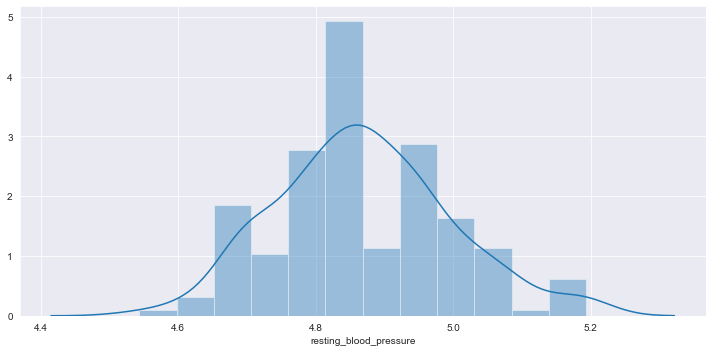

In [1358]:
# transforming to get closer to normal distribution
full_train['resting_blood_pressure'] = np.log(full_train['resting_blood_pressure'])
print('Transformed Skewness is', full_train['resting_blood_pressure'].skew())
plt.figure(figsize=(10,5))
sns.distplot(full_train['resting_blood_pressure'])

test["resting_blood_pressure"] = np.log(test["resting_blood_pressure"])

# kurtosis
print('Transformed Kurtosis is', full_train['resting_blood_pressure'].kurtosis())

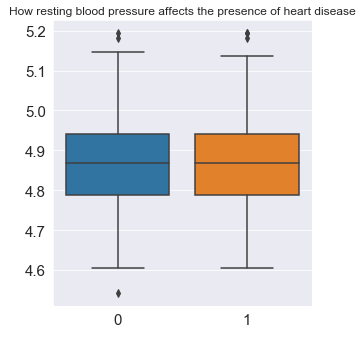

In [1359]:
# how does resting blood pressure affect the presence of heart disease?
plt.figure(figsize=(5,5))
sns.set_style("darkgrid")
b = sns.boxplot(x="heart_disease_present", y="resting_blood_pressure", data=full_train)
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("How resting blood pressure affects the presence of heart disease")
plt.ylabel(" ")
plt.xlabel(" ")
plt.show()

In [1360]:
# removing outliers
full_train[(full_train["heart_disease_present"] == 0) & (full_train["resting_blood_pressure"] < 4.6)]

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
130,0zldrz,1,reversible_defect,4.543295,3,1,0,0,227,0.0,1,51,154,1,0


In [1361]:
# removing the extreme outlier
full_train = full_train.drop(full_train[(full_train["heart_disease_present"] == 0) & (full_train["resting_blood_pressure"] < 4.6)].index,axis=0)

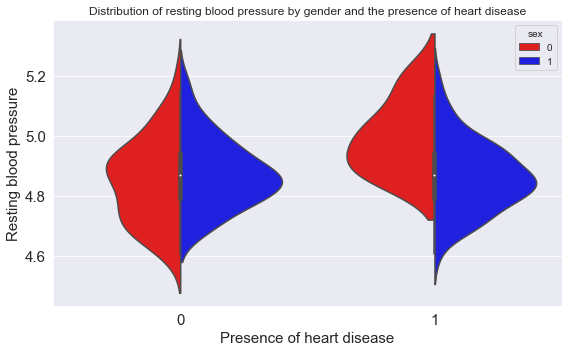

In [1362]:
# what is the distribution of resting blood pressure for those with heart disease and without?
plt.figure(figsize=(8,5))
sns.set_style("darkgrid")
b = sns.violinplot(x="heart_disease_present", y="resting_blood_pressure", data=full_train, hue="sex", split=True, palette={0:"r", 1:"b"})
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("Distribution of resting blood pressure by gender and the presence of heart disease")
plt.ylabel("Resting blood pressure")
plt.xlabel("Presence of heart disease")
plt.show()

For male, the resting blood pressure distribution is roughly the same with our without presence of heart disease.    
For female, the resting blood pressure distribution for presence of heart disease is higher.

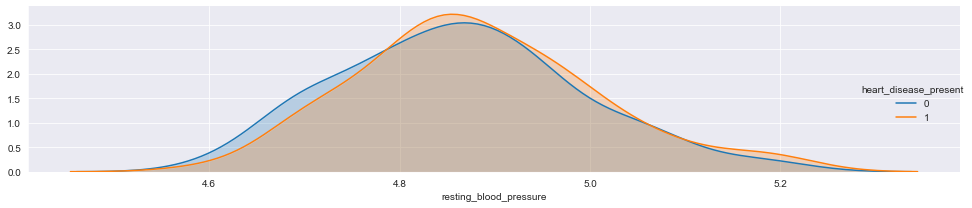

In [1363]:
a = sns.FacetGrid(full_train, hue="heart_disease_present", aspect=4)
a.map(sns.kdeplot, "resting_blood_pressure", shade=True)
a.add_legend()

The resting blood pressure of patients with heart disease is similar to patients without heart disease

### Feature: chest_pain_type

In [1364]:
full_train["chest_pain_type"].value_counts()

4    82
3    56
2    28
1    13
Name: chest_pain_type, dtype: int64

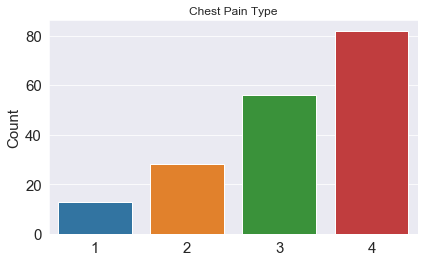

In [1365]:
sns.set_style("darkgrid")
b = sns.countplot(x="chest_pain_type", data=full_train)
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("Chest Pain Type")
plt.ylabel("Count")
plt.xlabel(" ")
plt.show()

In [1366]:
# how does chest pain type affect the presence of heart disease?
p4 = pd.crosstab(full_train["chest_pain_type"], full_train["heart_disease_present"])

In [1367]:
p4

heart_disease_present,0,1
chest_pain_type,,
1,9,4
2,24,4
3,43,13
4,23,59


In [1368]:
chest_1_heart_0 = p4[0][1]/(p4[0][1] + p4[1][1])*100
chest_1_heart_1 = p4[1][1]/(p4[0][1] + p4[1][1])*100
chest_2_heart_0 = p4[0][2]/(p4[0][2] + p4[1][2])*100
chest_2_heart_1 = p4[1][2]/(p4[0][2] + p4[1][2])*100
chest_3_heart_0 = p4[0][3]/(p4[0][3] + p4[1][3])*100
chest_3_heart_1 = p4[1][3]/(p4[0][3] + p4[1][3])*100
chest_4_heart_0 = p4[0][4]/(p4[0][4] + p4[1][4])*100
chest_4_heart_1 = p4[1][4]/(p4[0][4] + p4[1][4])*100

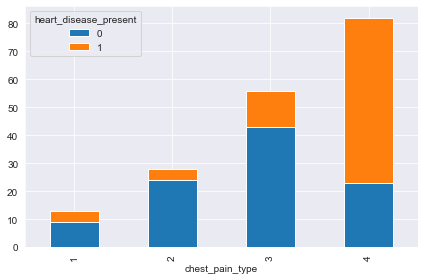

In [1369]:
p4.plot.bar(stacked=True)

In [1370]:
print("Percentage of patients with chest pain type 1 and no heart disease present {}".format(chest_1_heart_0))
print("Percentage of patients with chest pain type 1 and heart disease present {}".format(chest_1_heart_1))
print("Percentage of patients with chest pain type 2 and no heart disease present {}".format(chest_2_heart_0))
print("Percentage of patients with chest pain type 2 and heart disease present {}".format(chest_2_heart_1))
print("Percentage of patients with chest pain type 3 and no heart disease present {}".format(chest_3_heart_0))
print("Percentage of patients with chest pain type 3 and heart disease present {}".format(chest_3_heart_1))
print("Percentage of patients with chest pain type 4 and no heart disease present {}".format(chest_4_heart_0))
print("Percentage of patients with chest pain type 4 and heart disease present {}".format(chest_4_heart_1))

Percentage of patients with chest pain type 1 and no heart disease present 69.23076923076923
Percentage of patients with chest pain type 1 and heart disease present 30.76923076923077
Percentage of patients with chest pain type 2 and no heart disease present 85.71428571428571
Percentage of patients with chest pain type 2 and heart disease present 14.285714285714285
Percentage of patients with chest pain type 3 and no heart disease present 76.78571428571429
Percentage of patients with chest pain type 3 and heart disease present 23.214285714285715
Percentage of patients with chest pain type 4 and no heart disease present 28.04878048780488
Percentage of patients with chest pain type 4 and heart disease present 71.95121951219512


Patients with chest pain type 4 are more likely to have heart disease present

In [1371]:
full_train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,4.852030,2,0,0,2,308,0.0,1,45,170,0,0
1,ryoo3j,2,normal,4.700480,3,0,0,0,214,1.6,0,54,158,0,0
2,yt1s1x,1,normal,4.828314,4,3,0,2,304,0.0,1,77,162,1,1
3,l2xjde,1,reversible_defect,5.023881,4,0,0,0,223,0.0,1,40,181,0,1
4,oyt4ek,3,reversible_defect,5.181784,1,0,0,2,270,4.2,1,59,145,0,0





### Feature: num_major_vessels

In [1372]:
full_train["num_major_vessels"].value_counts()

0    106
1    36 
2    23 
3    14 
Name: num_major_vessels, dtype: int64

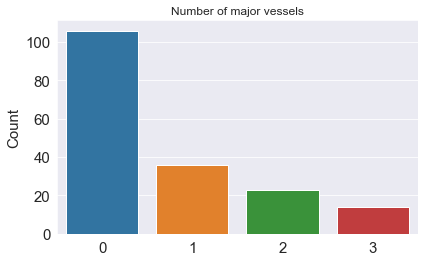

In [1373]:
sns.set_style("darkgrid")
b = sns.countplot(x="num_major_vessels", data=full_train)
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("Number of major vessels")
plt.ylabel("Count")
plt.xlabel(" ")
plt.show()

In [1374]:
# how does the number of major vessels affect the presence of heart disease?
p5 = pd.crosstab(full_train["num_major_vessels"], full_train["heart_disease_present"])

In [1375]:
p5

heart_disease_present,0,1
num_major_vessels,,
0,77,29
1,14,22
2,6,17
3,2,12


In [1376]:
num_0_heart_0 = p5[0][0]/(p5[0][0] + p5[1][0])*100
num_0_heart_1 = p5[1][0]/(p5[0][0] + p5[1][0])*100
num_1_heart_0 = p5[0][1]/(p5[0][1] + p5[1][1])*100
num_1_heart_1 = p5[1][1]/(p5[0][1] + p5[1][1])*100
num_2_heart_0 = p5[0][2]/(p5[0][2] + p5[1][2])*100
num_2_heart_1 = p5[1][2]/(p5[0][2] + p5[1][2])*100
num_3_heart_0 = p5[0][3]/(p5[0][3] + p5[1][3])*100
num_3_heart_1 = p5[1][3]/(p5[0][3] + p5[1][3])*100

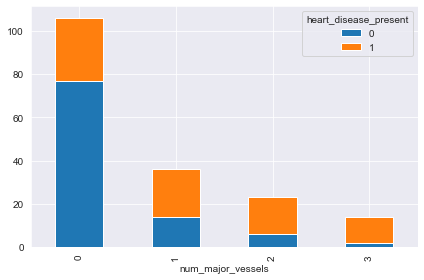

In [1377]:
p5.plot.bar(stacked=True)

In [1378]:
print("Percentage of patients with 0 major vessels and no heart disease present {}".format(num_0_heart_0))
print("Percentage of patients with 0 major vessels and heart disease present {}".format(num_0_heart_1))
print("Percentage of patients with 1 major vessels and no heart disease present {}".format(num_1_heart_0))
print("Percentage of patients with 1 major vessels and heart disease present {}".format(num_1_heart_1))
print("Percentage of patients with 2 major vessels and no heart disease present {}".format(num_2_heart_0))
print("Percentage of patients with 2 major vessels and heart disease present {}".format(num_2_heart_1))
print("Percentage of patients with 3 major vessels and no heart disease present {}".format(num_3_heart_0))
print("Percentage of patients with 3 major vessels and heart disease present {}".format(num_3_heart_1))

Percentage of patients with 0 major vessels and no heart disease present 72.64150943396226
Percentage of patients with 0 major vessels and heart disease present 27.358490566037734
Percentage of patients with 1 major vessels and no heart disease present 38.88888888888889
Percentage of patients with 1 major vessels and heart disease present 61.111111111111114
Percentage of patients with 2 major vessels and no heart disease present 26.08695652173913
Percentage of patients with 2 major vessels and heart disease present 73.91304347826086
Percentage of patients with 3 major vessels and no heart disease present 14.285714285714285
Percentage of patients with 3 major vessels and heart disease present 85.71428571428571


As the number of major vessels increases, the more likely heart disease is present

### Feature: fasting_blood_sugar_gt_120_mg_per_dl

Fasting blood sugar > 120 mg/dl 

In [1379]:
full_train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,4.852030,2,0,0,2,308,0.0,1,45,170,0,0
1,ryoo3j,2,normal,4.700480,3,0,0,0,214,1.6,0,54,158,0,0
2,yt1s1x,1,normal,4.828314,4,3,0,2,304,0.0,1,77,162,1,1
3,l2xjde,1,reversible_defect,5.023881,4,0,0,0,223,0.0,1,40,181,0,1
4,oyt4ek,3,reversible_defect,5.181784,1,0,0,2,270,4.2,1,59,145,0,0


In [1380]:
full_train["fasting_blood_sugar_gt_120_mg_per_dl"].value_counts()

0    150
1    29 
Name: fasting_blood_sugar_gt_120_mg_per_dl, dtype: int64

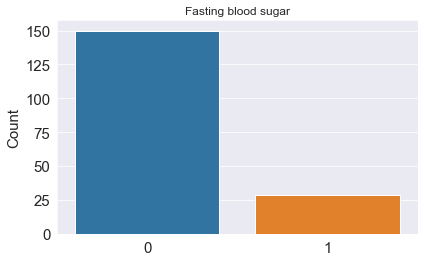

In [1381]:
sns.set_style("darkgrid")
b = sns.countplot(x="fasting_blood_sugar_gt_120_mg_per_dl", data=full_train)
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("Fasting blood sugar")
plt.ylabel("Count")
plt.xlabel(" ")
plt.show()

In [1382]:
# percentage of patients with heart disease 
p6 = pd.crosstab(full_train["fasting_blood_sugar_gt_120_mg_per_dl"], full_train["heart_disease_present"])

In [1383]:
p6

heart_disease_present,0,1
fasting_blood_sugar_gt_120_mg_per_dl,,
0,83,67
1,16,13


In [1384]:
fasting_0_heart_0 = p6[0][0]/(p6[0][0] + p6[1][0])*100
fasting_0_heart_1 = p6[1][0]/(p6[0][0] + p6[1][0])*100
fasting_1_heart_0 = p6[0][1]/(p6[0][1] + p6[1][1])*100
fasting_1_heart_1 = p6[1][1]/(p6[0][1] + p6[1][1])*100

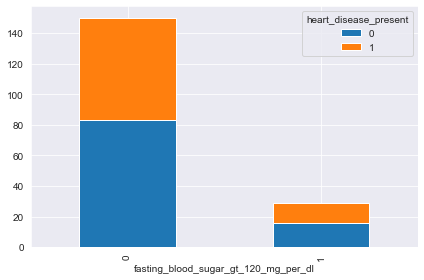

In [1385]:
p6.plot.bar(stacked=True)

In [1386]:
print("Percentage of patients with fasting blood sugar < 120ml and no heart disease present {}".format(fasting_0_heart_0))
print("Percentage of patients with fasting blood sugar < 120ml and heart disease present {}".format(fasting_0_heart_1))
print("Percentage of patients with fasting blood sugar > 120ml and no heart disease present {}".format(fasting_1_heart_0))
print("Percentage of patients with fasting blood sugar > 120ml and heart disease present {}".format(fasting_1_heart_1))

Percentage of patients with fasting blood sugar < 120ml and no heart disease present 55.333333333333336
Percentage of patients with fasting blood sugar < 120ml and heart disease present 44.666666666666664
Percentage of patients with fasting blood sugar > 120ml and no heart disease present 55.172413793103445
Percentage of patients with fasting blood sugar > 120ml and heart disease present 44.827586206896555


The fasting blood sugar level does not seem to have much impact on the presence of heart disease

In [1387]:
full_train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,4.852030,2,0,0,2,308,0.0,1,45,170,0,0
1,ryoo3j,2,normal,4.700480,3,0,0,0,214,1.6,0,54,158,0,0
2,yt1s1x,1,normal,4.828314,4,3,0,2,304,0.0,1,77,162,1,1
3,l2xjde,1,reversible_defect,5.023881,4,0,0,0,223,0.0,1,40,181,0,1
4,oyt4ek,3,reversible_defect,5.181784,1,0,0,2,270,4.2,1,59,145,0,0


### Feature: resting_ekg_results

Resting electrocardiographic results (values 0,1,2)   

In [1388]:
full_train["resting_ekg_results"].value_counts()

2    94
0    84
1    1 
Name: resting_ekg_results, dtype: int64

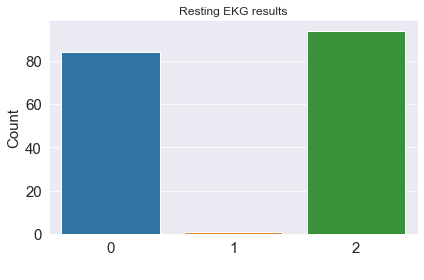

In [1389]:
sns.set_style("darkgrid")
b = sns.countplot("resting_ekg_results", data=full_train)
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("Resting EKG results")
plt.ylabel("Count")
plt.xlabel(" ")
plt.show()

In [1390]:
p7 = pd.crosstab(full_train["resting_ekg_results"], full_train["heart_disease_present"])

In [1391]:
p7

heart_disease_present,0,1
resting_ekg_results,,
0,53,31
1,0,1
2,46,48


In [1392]:
resting_0_heart_0 = p7[0][0]/(p7[0][0] + p7[1][0])*100
resting_0_heart_1 = p7[1][0]/(p7[0][0] + p7[1][0])*100
resting_1_heart_0 = p7[0][1]/(p7[0][1] + p7[1][1])*100
resting_1_heart_1 = p7[1][1]/(p7[0][1] + p7[1][1])*100
resting_2_heart_0 = p7[0][2]/(p7[0][2] + p7[1][2])*100
resting_2_heart_1 = p7[1][2]/(p7[0][2] + p7[1][2])*100

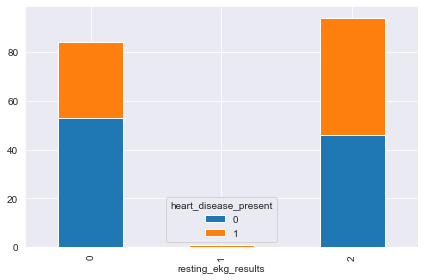

In [1393]:
p7.plot.bar(stacked=True)

In [1394]:
print("Percentage of patients with ekg result 0 and no heart disease present {}".format(resting_0_heart_0))
print("Percentage of patients with ekg result 0 and heart disease present {}".format(resting_0_heart_1))
print("Percentage of patients with ekg result 1 and no heart disease present {}".format(resting_1_heart_0))
print("Percentage of patients with ekg reuslt 1 and heart disease present {}".format(resting_1_heart_1))
print("Percentage of patients with ekg result 2 and no heart disease present {}".format(resting_2_heart_0))
print("Percentage of patients with ekg result 2 and heart disease present {}".format(resting_2_heart_1))

Percentage of patients with ekg result 0 and no heart disease present 63.095238095238095
Percentage of patients with ekg result 0 and heart disease present 36.904761904761905
Percentage of patients with ekg result 1 and no heart disease present 0.0
Percentage of patients with ekg reuslt 1 and heart disease present 100.0
Percentage of patients with ekg result 2 and no heart disease present 48.93617021276596
Percentage of patients with ekg result 2 and heart disease present 51.06382978723404


The relationship between is not so obvious as we don't have enough observations for resting_ekg_results == 1.   
However, it seems like the as resting_ekg_results increases, the chances of being diagnose with heart disease is higher.

In [1395]:
full_train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,4.852030,2,0,0,2,308,0.0,1,45,170,0,0
1,ryoo3j,2,normal,4.700480,3,0,0,0,214,1.6,0,54,158,0,0
2,yt1s1x,1,normal,4.828314,4,3,0,2,304,0.0,1,77,162,1,1
3,l2xjde,1,reversible_defect,5.023881,4,0,0,0,223,0.0,1,40,181,0,1
4,oyt4ek,3,reversible_defect,5.181784,1,0,0,2,270,4.2,1,59,145,0,0


### Feature: serum_cholesterol_mg_per_dl

In [1396]:
full_train["serum_cholesterol_mg_per_dl"].describe()

count    179.000000
mean     249.335196
std      52.839480 
min      126.000000
25%      213.500000
50%      246.000000
75%      281.500000
max      564.000000
Name: serum_cholesterol_mg_per_dl, dtype: float64

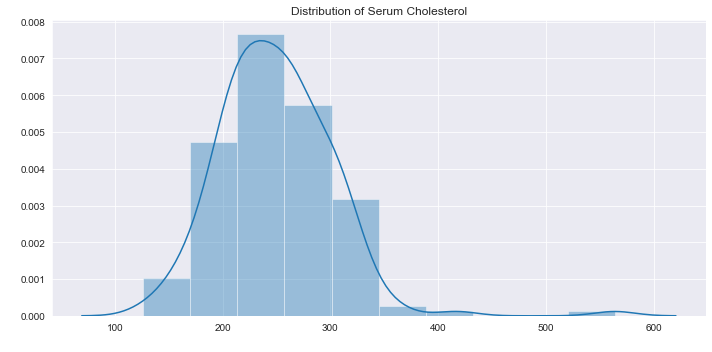

In [1397]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
p3 = sns.distplot(full_train["serum_cholesterol_mg_per_dl"],kde=True,bins=10)
b.axes.set_title("Title",fontsize=30)
b.set_xlabel("X Label",fontsize=20)
b.set_ylabel("Y Label",fontsize=20)
b.tick_params(labelsize=15)
plt.title("Distribution of Serum Cholesterol")
plt.ylabel(" ")
plt.xlabel(" ")
plt.show()

In [1398]:
# skewness and kurtosis
print("Skewness: {}".format(full_train["serum_cholesterol_mg_per_dl"].skew()))
print("Kurtosis: {}".format(full_train["serum_cholesterol_mg_per_dl"].kurtosis()))
print("Mean:  {}".format(np.mean(full_train["serum_cholesterol_mg_per_dl"])))
print("Variance: {}".format(np.var(full_train["serum_cholesterol_mg_per_dl"])))

Skewness: 1.2656479676978345
Kurtosis: 6.31962907629632
Mean:  249.33519553072625
Variance: 2776.4127836209855


Transformed Skewness is -0.025701377185663146
Transformed Kurtosis is 1.3459397434832283


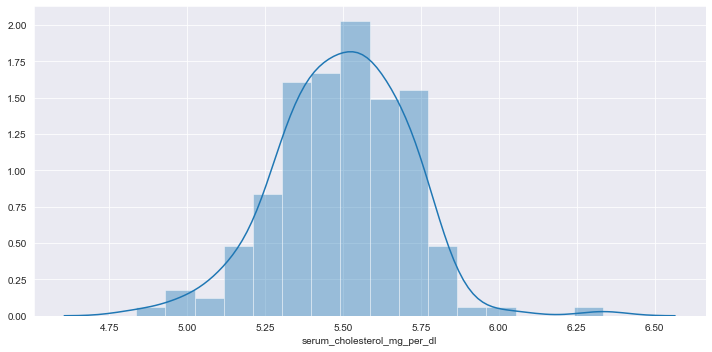

In [1399]:
# transforming to get closer to normal distribution
full_train['serum_cholesterol_mg_per_dl'] = np.log(full_train['serum_cholesterol_mg_per_dl'])
print('Transformed Skewness is', full_train['serum_cholesterol_mg_per_dl'].skew())
plt.figure(figsize=(10,5))
sns.distplot(full_train['serum_cholesterol_mg_per_dl'])

test["serum_cholesterol_mg_per_dl"] = np.log(test["serum_cholesterol_mg_per_dl"])

# kurtosis
print('Transformed Kurtosis is', full_train['serum_cholesterol_mg_per_dl'].kurtosis())

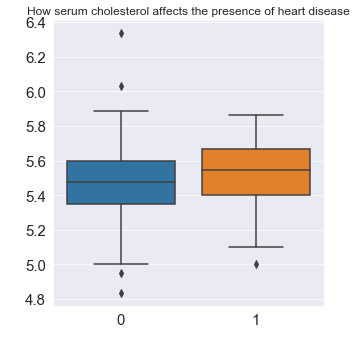

In [1400]:
# how does resting blood pressure affect the presence of heart disease?
plt.figure(figsize=(5,5))
sns.set_style("darkgrid")
b = sns.boxplot(x="heart_disease_present", y="serum_cholesterol_mg_per_dl", data=full_train)
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("How serum cholesterol affects the presence of heart disease")
plt.ylabel(" ")
plt.xlabel(" ")
plt.show()

In [1401]:
# removing outliers
full_train[(full_train["heart_disease_present"] == 1) & (full_train["serum_cholesterol_mg_per_dl"] < 5.005)]

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
85,hfp05i,1,normal,4.770685,3,3,0,2,5.003946,0.8,1,49,126,0,1


In [1402]:
full_train[(full_train["heart_disease_present"] == 0) & (full_train["serum_cholesterol_mg_per_dl"] > 5.9)]

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
43,yx0q6k,1,normal,4.941642,3,1,1,2,6.033086,0.8,0,65,157,0,0
60,rv6siv,2,reversible_defect,4.744932,3,0,0,2,6.335054,1.6,0,67,160,0,0


In [1403]:
full_train[(full_train["heart_disease_present"] == 0) & (full_train["serum_cholesterol_mg_per_dl"] < 5.0)]

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
36,xkdz7j,1,reversible_defect,5.010635,3,1,1,0,4.836282,0.2,1,57,173,0,0
94,7uch9x,2,normal,4.682131,3,0,0,0,4.948760,0.6,0,44,175,0,0


In [1404]:
# removing the extreme outlier
full_train = full_train.drop(full_train[(full_train["heart_disease_present"] == 1) & (full_train["serum_cholesterol_mg_per_dl"] < 5.005)].index,axis=0)

In [1405]:
full_train = full_train.drop(full_train[(full_train["heart_disease_present"] == 0) & (full_train["serum_cholesterol_mg_per_dl"] > 5.9)].index,axis=0)

In [1406]:
full_train = full_train.drop(full_train[(full_train["heart_disease_present"] == 0) & (full_train["serum_cholesterol_mg_per_dl"] < 5.0)].index,axis=0)

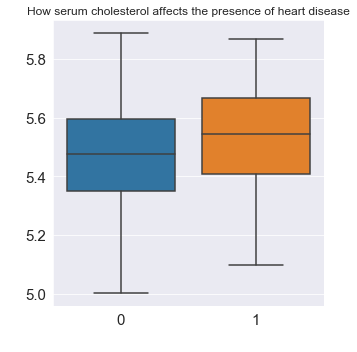

In [1407]:
# boxplot after removing the outliers
plt.figure(figsize=(5,5))
sns.set_style("darkgrid")
b = sns.boxplot(x="heart_disease_present", y="serum_cholesterol_mg_per_dl", data=full_train)
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("How serum cholesterol affects the presence of heart disease")
plt.ylabel(" ")
plt.xlabel(" ")
plt.show()

Patients with higher serum cholesterol level are more likely to be diagnose with heart disease

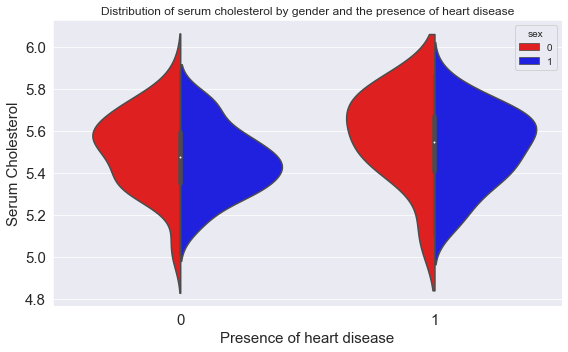

In [1408]:
# what is the distribution of serum cholesterol for those with heart disease and without?
plt.figure(figsize=(8,5))
sns.set_style("darkgrid")
b = sns.violinplot(x="heart_disease_present", y="serum_cholesterol_mg_per_dl", data=full_train, hue="sex", split=True, palette={0:"r", 1:"b"})
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("Distribution of serum cholesterol by gender and the presence of heart disease")
plt.ylabel("Serum Cholesterol")
plt.xlabel("Presence of heart disease")
plt.show()

Females tend to have higher serum cholesterol level as compared to males.

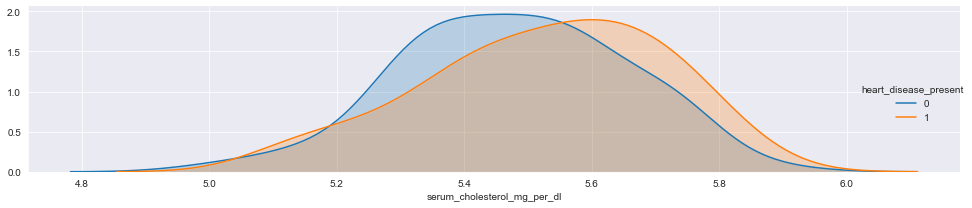

In [1409]:
a = sns.FacetGrid(full_train, hue="heart_disease_present", aspect=4)
a.map(sns.kdeplot, "serum_cholesterol_mg_per_dl", shade=True)
a.add_legend()

Similar to the conclusion of the boxplot, patients with heart disease tend to have higher serum cholesterol.

In [1410]:
full_train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,4.852030,2,0,0,2,5.730100,0.0,1,45,170,0,0
1,ryoo3j,2,normal,4.700480,3,0,0,0,5.365976,1.6,0,54,158,0,0
2,yt1s1x,1,normal,4.828314,4,3,0,2,5.717028,0.0,1,77,162,1,1
3,l2xjde,1,reversible_defect,5.023881,4,0,0,0,5.407172,0.0,1,40,181,0,1
4,oyt4ek,3,reversible_defect,5.181784,1,0,0,2,5.598422,4.2,1,59,145,0,0


### Feature: oldpeak_eq_st_depression

oldpeak = ST depression induced by exercise relative to rest, a measure of abnormality in electrocardiograms   

In [1411]:
full_train["oldpeak_eq_st_depression"].describe()

count    174.000000
mean     1.021839  
std      1.134781  
min      0.000000  
25%      0.000000  
50%      0.800000  
75%      1.600000  
max      6.200000  
Name: oldpeak_eq_st_depression, dtype: float64

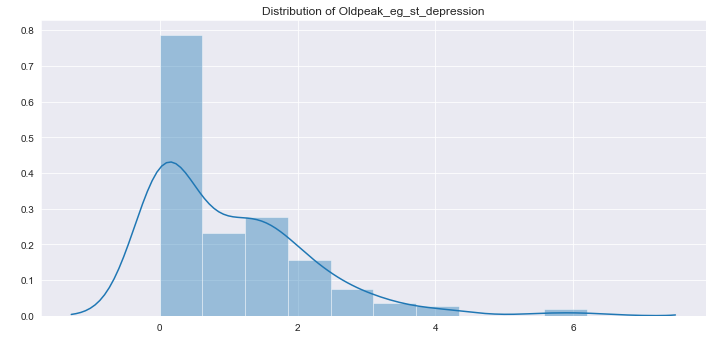

In [1412]:
# what is the distribution?
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
p3 = sns.distplot(full_train["oldpeak_eq_st_depression"],kde=True,bins=10)
b.axes.set_title("Title",fontsize=30)
b.set_xlabel("X Label",fontsize=20)
b.set_ylabel("Y Label",fontsize=20)
b.tick_params(labelsize=15)
plt.title("Distribution of Oldpeak_eg_st_depression")
plt.ylabel(" ")
plt.xlabel(" ")
plt.show()

In [1413]:
# skewness and kurtosis
print("Skewness: {}".format(full_train["oldpeak_eq_st_depression"].skew()))
print("Kurtosis: {}".format(full_train["oldpeak_eq_st_depression"].kurtosis()))
print("Mean:  {}".format(np.mean(full_train["oldpeak_eq_st_depression"])))
print("Variance: {}".format(np.var(full_train["oldpeak_eq_st_depression"])))

Skewness: 1.4796891762650577
Kurtosis: 3.094054523351399
Mean:  1.0218390804597701
Variance: 1.2803276522658211


Transformed Skewness is 0.14091388931481152
Transformed Kurtosis is -1.0586308227884438


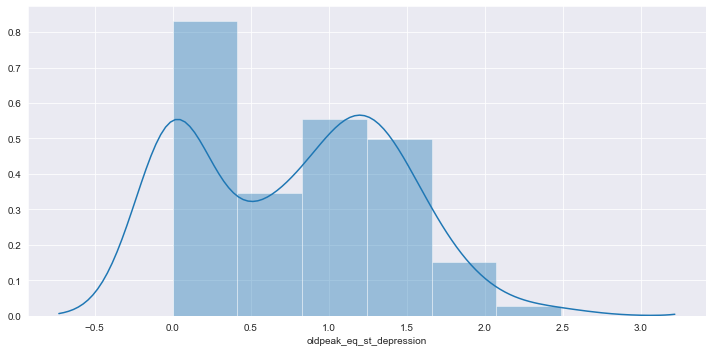

In [1414]:
# transforming to get closer to normal distribution
full_train['oldpeak_eq_st_depression'] = np.sqrt(full_train['oldpeak_eq_st_depression'])
print('Transformed Skewness is', full_train['oldpeak_eq_st_depression'].skew())
plt.figure(figsize=(10,5))
sns.distplot(full_train['oldpeak_eq_st_depression'])

test["oldpeak_eq_st_depression"] = np.sqrt(test["oldpeak_eq_st_depression"])

# kurtosis
print('Transformed Kurtosis is', full_train['oldpeak_eq_st_depression'].kurtosis())

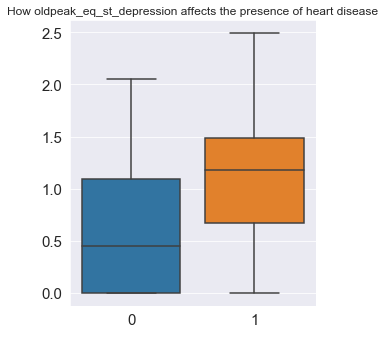

In [1415]:
# how does resting blood pressure affect the presence of heart disease?
plt.figure(figsize=(5,5))
sns.set_style("darkgrid")
b = sns.boxplot(x="heart_disease_present", y="oldpeak_eq_st_depression", data=full_train)
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("How oldpeak_eq_st_depression affects the presence of heart disease")
plt.ylabel(" ")
plt.xlabel(" ")
plt.show()

Patients with higher oldpeak_eq_st_depression level are more likely to be diagnose with heart disease

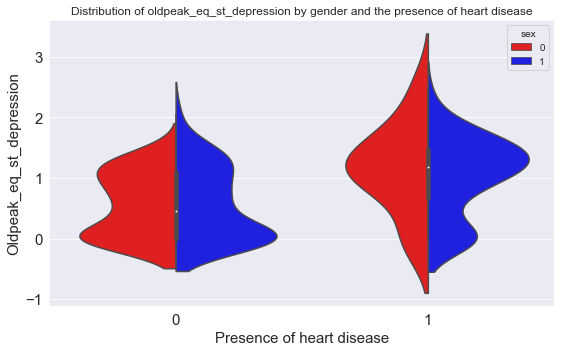

In [1416]:
# what is the distribution of oldpeak_eq_st_depression for those with heart disease and without?
plt.figure(figsize=(8,5))
sns.set_style("darkgrid")
b = sns.violinplot(x="heart_disease_present", y="oldpeak_eq_st_depression", data=full_train, hue="sex", split=True, palette={0:"r", 1:"b"})
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("Distribution of oldpeak_eq_st_depression by gender and the presence of heart disease")
plt.ylabel("Oldpeak_eq_st_depression")
plt.xlabel("Presence of heart disease")
plt.show()

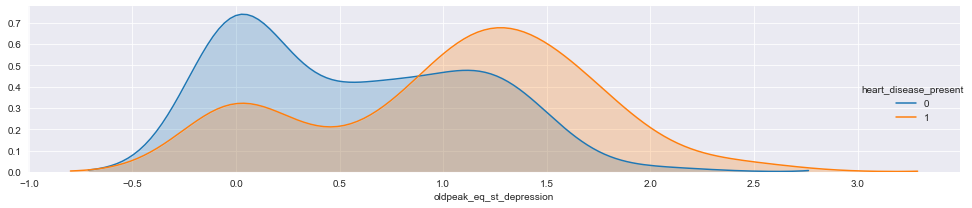

In [1417]:
a = sns.FacetGrid(full_train, hue="heart_disease_present", aspect=4)
a.map(sns.kdeplot, "oldpeak_eq_st_depression", shade=True)
a.add_legend()

Similar to the conclusion from boxplot, patients diagnosed with heart disease tend to have higher oldpeak_eq_st_depression

In [1418]:
full_train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,4.852030,2,0,0,2,5.730100,0.000000,1,45,170,0,0
1,ryoo3j,2,normal,4.700480,3,0,0,0,5.365976,1.264911,0,54,158,0,0
2,yt1s1x,1,normal,4.828314,4,3,0,2,5.717028,0.000000,1,77,162,1,1
3,l2xjde,1,reversible_defect,5.023881,4,0,0,0,5.407172,0.000000,1,40,181,0,1
4,oyt4ek,3,reversible_defect,5.181784,1,0,0,2,5.598422,2.049390,1,59,145,0,0


### Feature: sex

In [1419]:
full_train["sex"].value_counts()

1    121
0    53 
Name: sex, dtype: int64

### Feature: age

In [1420]:
full_train["age"].describe()

count    174.000000
mean     54.787356 
std      9.365764  
min      29.000000 
25%      48.000000 
50%      55.000000 
75%      62.000000 
max      77.000000 
Name: age, dtype: float64

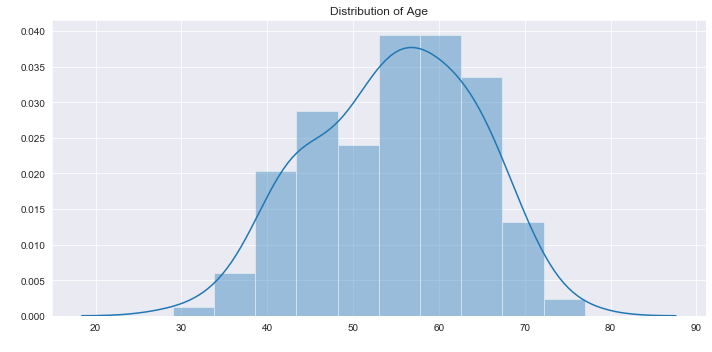

In [1421]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
p3 = sns.distplot(full_train["age"],kde=True,bins=10)
b.axes.set_title("Title",fontsize=30)
b.set_xlabel("X Label",fontsize=20)
b.set_ylabel("Y Label",fontsize=20)
b.tick_params(labelsize=15)
plt.title("Distribution of Age")
plt.ylabel(" ")
plt.xlabel(" ")
plt.show()

In [1422]:
# skewness and kurtosis
print("Skewness: {}".format(full_train["age"].skew()))
print("Kurtosis: {}".format(full_train["age"].kurtosis()))
print("Mean:  {}".format(np.mean(full_train["age"])))
print("Variance: {}".format(np.var(full_train["age"])))

Skewness: -0.20612149259246557
Kurtosis: -0.5533572449079536
Mean:  54.78735632183908
Variance: 87.2134033557933


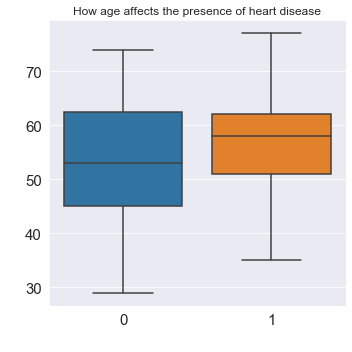

In [1423]:
# how does age affect the presence of heart disease?
plt.figure(figsize=(5,5))
sns.set_style("darkgrid")
b = sns.boxplot(x="heart_disease_present", y="age", data=full_train)
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("How age affects the presence of heart disease")
plt.ylabel(" ")
plt.xlabel(" ")
plt.show()

Patients diagnosed with heart disease are older

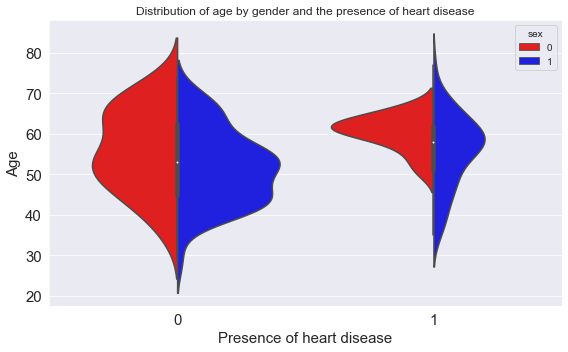

In [1424]:
# what is the distribution of oldpeak_eq_st_depression for those with heart disease and without?
plt.figure(figsize=(8,5))
sns.set_style("darkgrid")
b = sns.violinplot(x="heart_disease_present", y="age", data=full_train, hue="sex", split=True, palette={0:"r", 1:"b"})
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("Distribution of age by gender and the presence of heart disease")
plt.ylabel("Age")
plt.xlabel("Presence of heart disease")
plt.show()

Female patients diagnosed with heart disease are mostly around 60 years old

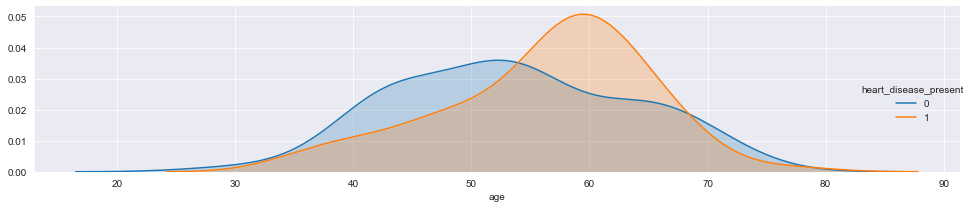

In [1425]:
a = sns.FacetGrid(full_train, hue="heart_disease_present", aspect=4)
a.map(sns.kdeplot, "age", shade=True)
a.add_legend()

Similar to the conclusion from boxplot, patients diagnosed with heart disease are older

In [1426]:
full_train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,4.852030,2,0,0,2,5.730100,0.000000,1,45,170,0,0
1,ryoo3j,2,normal,4.700480,3,0,0,0,5.365976,1.264911,0,54,158,0,0
2,yt1s1x,1,normal,4.828314,4,3,0,2,5.717028,0.000000,1,77,162,1,1
3,l2xjde,1,reversible_defect,5.023881,4,0,0,0,5.407172,0.000000,1,40,181,0,1
4,oyt4ek,3,reversible_defect,5.181784,1,0,0,2,5.598422,2.049390,1,59,145,0,0


### Feature: max_heart_rate_achieved

In [1427]:
full_train["max_heart_rate_achieved"].describe()

count    174.000000
mean     149.206897
std      22.189482 
min      96.000000 
25%      132.000000
50%      151.500000
75%      166.000000
max      202.000000
Name: max_heart_rate_achieved, dtype: float64

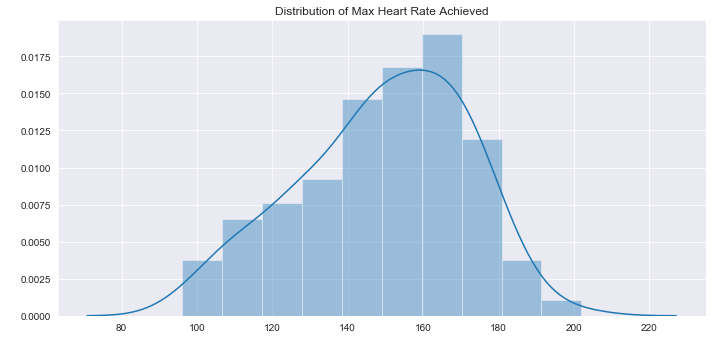

In [1428]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
p3 = sns.distplot(full_train["max_heart_rate_achieved"],kde=True,bins=10)
b.axes.set_title("Title",fontsize=30)
b.set_xlabel("X Label",fontsize=20)
b.set_ylabel("Y Label",fontsize=20)
b.tick_params(labelsize=15)
plt.title("Distribution of Max Heart Rate Achieved")
plt.ylabel(" ")
plt.xlabel(" ")
plt.show()

In [1429]:
# skewness and kurtosis
print("Skewness: {}".format(full_train["max_heart_rate_achieved"].skew()))
print("Kurtosis: {}".format(full_train["max_heart_rate_achieved"].kurtosis()))
print("Mean:  {}".format(np.mean(full_train["max_heart_rate_achieved"])))
print("Variance: {}".format(np.var(full_train["max_heart_rate_achieved"])))

Skewness: -0.3726263643981302
Kurtosis: -0.4983810135534634
Mean:  149.20689655172413
Variance: 489.54340071343614


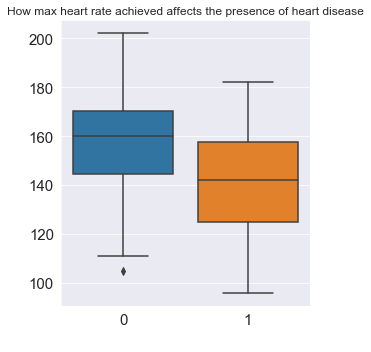

In [1430]:
# how does age affect the presence of heart disease?
plt.figure(figsize=(5,5))
sns.set_style("darkgrid")
b = sns.boxplot(x="heart_disease_present", y="max_heart_rate_achieved", data=full_train)
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("How max heart rate achieved affects the presence of heart disease")
plt.ylabel(" ")
plt.xlabel(" ")
plt.show()

In [1431]:
# removing outliers
full_train[(full_train["heart_disease_present"] == 0) & (full_train["max_heart_rate_achieved"] < 110)]


,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
110,0g192k,2,reversible_defect,4.85203,4,1,0,0,5.572154,0.447214,1,64,105,1,0


In [1432]:

# removing the extreme outlier
full_train = full_train.drop(full_train[(full_train["heart_disease_present"] == 0) & (full_train["max_heart_rate_achieved"] < 110)].index,axis=0)

Patients diagnosed with heart disease have a much lower max heart rate achieved

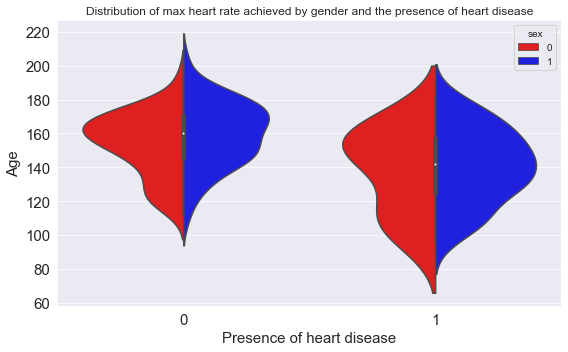

In [1433]:
# what is the distribution of max heart rate achieved for those with heart disease and without?
plt.figure(figsize=(8,5))
sns.set_style("darkgrid")
b = sns.violinplot(x="heart_disease_present", y="max_heart_rate_achieved", data=full_train, hue="sex", split=True, palette={0:"r", 1:"b"})
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("Distribution of max heart rate achieved by gender and the presence of heart disease")
plt.ylabel("Age")
plt.xlabel("Presence of heart disease")
plt.show()

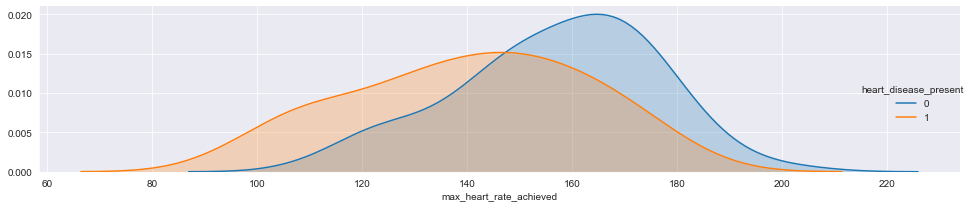

In [1434]:
a = sns.FacetGrid(full_train, hue="heart_disease_present", aspect=4)
a.map(sns.kdeplot, "max_heart_rate_achieved", shade=True)
a.add_legend()

Similar to the conclusion from boxplot, patients diagnosed with heart disease have a lower max heart rate

In [1435]:
full_train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,4.852030,2,0,0,2,5.730100,0.000000,1,45,170,0,0
1,ryoo3j,2,normal,4.700480,3,0,0,0,5.365976,1.264911,0,54,158,0,0
2,yt1s1x,1,normal,4.828314,4,3,0,2,5.717028,0.000000,1,77,162,1,1
3,l2xjde,1,reversible_defect,5.023881,4,0,0,0,5.407172,0.000000,1,40,181,0,1
4,oyt4ek,3,reversible_defect,5.181784,1,0,0,2,5.598422,2.049390,1,59,145,0,0


### Feature: exercise_induced_angina

exercise-induced chest pain (0: False, 1: True)

In [1436]:
full_train["exercise_induced_angina"].value_counts()

0    118
1    55 
Name: exercise_induced_angina, dtype: int64

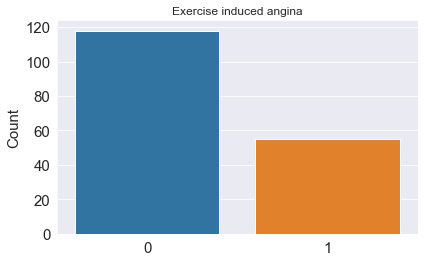

In [1437]:
sns.set_style("darkgrid")
b = sns.countplot("exercise_induced_angina", data=full_train)
b.axes.set_title("Title",fontsize=10)
b.set_xlabel("X Label",fontsize=15)
b.set_ylabel("Y Label",fontsize=15)
b.tick_params(labelsize=15)
plt.title("Exercise induced angina")
plt.ylabel("Count")
plt.xlabel(" ")
plt.show()

In [1438]:
# how does exercise induced agina affect the presence of heart disease?
p8 = pd.crosstab(full_train["exercise_induced_angina"], full_train["heart_disease_present"])

In [1439]:
p8

heart_disease_present,0,1
exercise_induced_angina,,
0,83,35
1,11,44


In [1440]:
exercise_0_heart_0 = p8[0][0]/(p8[0][0] + p8[1][0])*100
exercise_0_heart_1 = p8[1][0]/(p8[0][0] + p8[1][0])*100
exercise_1_heart_0 = p8[0][1]/(p8[0][1] + p8[1][1])*100
exercise_1_heart_1 = p8[1][1]/(p8[0][1] + p8[1][1])*100

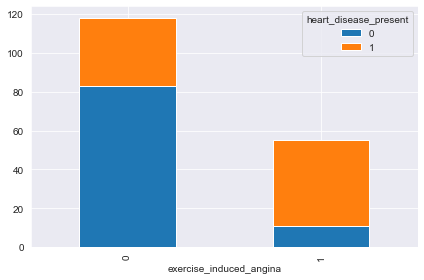

In [1441]:
p8.plot.bar(stacked=True)

In [1442]:
print("Percentage of patients with no exercise induced angina and no heart disease present {}".format(exercise_0_heart_0))
print("Percentage of patients with no exercise induced angina and heart disease present {}".format(exercise_0_heart_1))
print("Percentage of patients with exercise induced angina and no heart disease present {}".format(exercise_1_heart_0))
print("Percentage of patients with exercise induced angina and heart disease present {}".format(exercise_1_heart_1))

Percentage of patients with no exercise induced angina and no heart disease present 70.33898305084746
Percentage of patients with no exercise induced angina and heart disease present 29.66101694915254
Percentage of patients with exercise induced angina and no heart disease present 20.0
Percentage of patients with exercise induced angina and heart disease present 80.0


Patients diagnosed with heart disease typically experience chest pain

### Target Variable: heart_disease_present

In [1443]:
full_train["heart_disease_present"].value_counts()

0    94
1    79
Name: heart_disease_present, dtype: int64

The classes are quite evenly split so we dont have to do any resampling

### Correlation

In [1444]:
full_train.dtypes

patient_id                              object 
slope_of_peak_exercise_st_segment       object 
thal                                    object 
resting_blood_pressure                  float64
chest_pain_type                         object 
num_major_vessels                       int64  
fasting_blood_sugar_gt_120_mg_per_dl    object 
resting_ekg_results                     object 
serum_cholesterol_mg_per_dl             float64
oldpeak_eq_st_depression                float64
sex                                     object 
age                                     int64  
max_heart_rate_achieved                 int64  
exercise_induced_angina                 object 
heart_disease_present                   object 
dtype: object

In [1445]:
# correlation plot for car type and features
full_train_numerical = full_train.loc[:,["resting_blood_pressure", "num_major_vessels", "serum_cholesterol_mg_per_dl",
                               "oldpeak_eq_st_depression", "age", "max_heart_rate_achieved"]]

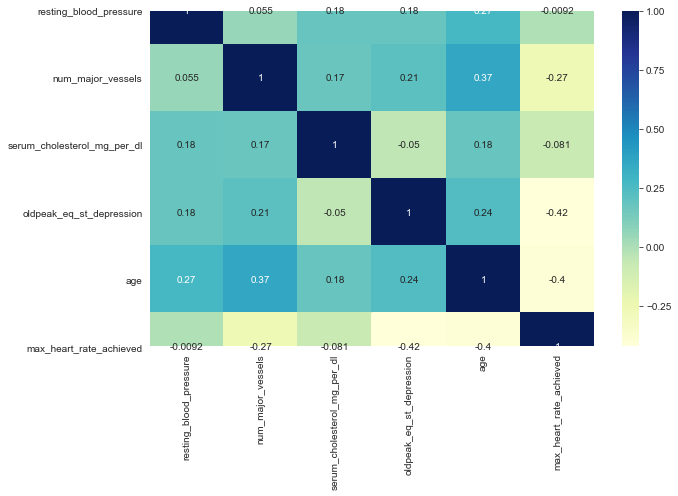

In [1446]:
plt.figure(figsize=(10,7))
sns.heatmap(full_train_numerical.corr(), cmap="YlGnBu", annot=True)

In [1447]:
corr_matrix = full_train_numerical.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
print(sol)

oldpeak_eq_st_depression     max_heart_rate_achieved        0.422309
age                          max_heart_rate_achieved        0.401846
num_major_vessels            age                            0.365995
resting_blood_pressure       age                            0.274835
num_major_vessels            max_heart_rate_achieved        0.265558
oldpeak_eq_st_depression     age                            0.242409
num_major_vessels            oldpeak_eq_st_depression       0.207353
serum_cholesterol_mg_per_dl  age                            0.183240
resting_blood_pressure       serum_cholesterol_mg_per_dl    0.183195
                             oldpeak_eq_st_depression       0.178012
num_major_vessels            serum_cholesterol_mg_per_dl    0.172351
serum_cholesterol_mg_per_dl  max_heart_rate_achieved        0.080608
resting_blood_pressure       num_major_vessels              0.055089
serum_cholesterol_mg_per_dl  oldpeak_eq_st_depression       0.049573
resting_blood_pressure       max_h

In [1448]:
full_train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,4.852030,2,0,0,2,5.730100,0.000000,1,45,170,0,0
1,ryoo3j,2,normal,4.700480,3,0,0,0,5.365976,1.264911,0,54,158,0,0
2,yt1s1x,1,normal,4.828314,4,3,0,2,5.717028,0.000000,1,77,162,1,1
3,l2xjde,1,reversible_defect,5.023881,4,0,0,0,5.407172,0.000000,1,40,181,0,1
4,oyt4ek,3,reversible_defect,5.181784,1,0,0,2,5.598422,2.049390,1,59,145,0,0


### Encoding Categorical Variables

In [1449]:
# slope_of_peak_exercise
slope_train = pd.get_dummies(full_train["slope_of_peak_exercise_st_segment"], prefix='slope', drop_first=True)
full_train = pd.concat([full_train, slope_train],axis=1)

slope_test = pd.get_dummies(test["slope_of_peak_exercise_st_segment"], prefix='slope', drop_first=True)
test = pd.concat([test, slope_test],axis=1)

In [1450]:
# thal
thal_train = pd.get_dummies(full_train["thal"], prefix="thal", drop_first=True)
full_train = pd.concat([full_train, thal_train], axis=1)

thal_test = pd.get_dummies(test["thal"], prefix="thal", drop_first=True)
test = pd.concat([test, thal_test],axis=1)

In [1451]:
# chest pain type
chest_train = pd.get_dummies(full_train["chest_pain_type"], prefix="chest_pain_type", drop_first=True)
full_train = pd.concat([full_train, chest_train],axis=1)

chest_test = pd.get_dummies(test["chest_pain_type"], prefix="chest_pain_type", drop_first=True)
test = pd.concat([test, chest_test],axis=1)

In [1452]:
# fasting blood sugar
blood_sugar_train = pd.get_dummies(full_train["fasting_blood_sugar_gt_120_mg_per_dl"], prefix="blood_sugar", drop_first=True)
full_train = pd.concat([full_train, blood_sugar_train],axis=1)

blood_sugar_test = pd.get_dummies(test["fasting_blood_sugar_gt_120_mg_per_dl"], prefix="blood_sugar", drop_first=True)
test = pd.concat([test, blood_sugar_test],axis=1)

In [1453]:
# resting ekg result
resting_ekg_train = pd.get_dummies(full_train["resting_ekg_results"], prefix="resting_ekg", drop_first=True)
full_train = pd.concat([full_train, resting_ekg_train],axis=1)

resting_ekg_test = pd.get_dummies(test["resting_ekg_results"], prefix="resting_ekg", drop_first=True)
test = pd.concat([test, resting_ekg_test],axis=1)

## 5. Data Modelling Preparation

Now we drop columns we don't need for our model

In [1454]:
full_train.columns

Index(['patient_id', 'slope_of_peak_exercise_st_segment', 'thal',
       'resting_blood_pressure', 'chest_pain_type', 'num_major_vessels',
       'fasting_blood_sugar_gt_120_mg_per_dl', 'resting_ekg_results',
       'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'sex', 'age',
       'max_heart_rate_achieved', 'exercise_induced_angina',
       'heart_disease_present', 'slope_2', 'slope_3', 'thal_normal',
       'thal_reversible_defect', 'chest_pain_type_2', 'chest_pain_type_3',
       'chest_pain_type_4', 'blood_sugar_1', 'resting_ekg_1', 'resting_ekg_2'],
      dtype='object')

In [1455]:
full_train_model = full_train.loc[:,['resting_blood_pressure', 'num_major_vessels', 'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'sex', 'age',
       'max_heart_rate_achieved', 'exercise_induced_angina',
       'heart_disease_present', 'slope_2', 'slope_3','thal_normal', 'thal_reversible_defect',
       'chest_pain_type_2', 'chest_pain_type_3', 'chest_pain_type_4',
       'blood_sugar_1', 'resting_ekg_1', 'resting_ekg_2']]

In [1456]:
full_train_model.head()

,resting_blood_pressure,num_major_vessels,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present,slope_2,slope_3,thal_normal,thal_reversible_defect,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,blood_sugar_1,resting_ekg_1,resting_ekg_2
0,4.852030,0,5.730100,0.000000,1,45,170,0,0,0,0,1,0,1,0,0,0,0,1
1,4.700480,0,5.365976,1.264911,0,54,158,0,0,1,0,1,0,0,1,0,0,0,0
2,4.828314,3,5.717028,0.000000,1,77,162,1,1,0,0,1,0,0,0,1,0,0,1
3,5.023881,0,5.407172,0.000000,1,40,181,0,1,0,0,0,1,0,0,1,0,0,0
4,5.181784,0,5.598422,2.049390,1,59,145,0,0,0,1,0,1,0,0,0,0,0,1


In [1457]:
test.columns

Index(['patient_id', 'slope_of_peak_exercise_st_segment', 'thal',
       'resting_blood_pressure', 'chest_pain_type', 'num_major_vessels',
       'fasting_blood_sugar_gt_120_mg_per_dl', 'resting_ekg_results',
       'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'sex', 'age',
       'max_heart_rate_achieved', 'exercise_induced_angina', 'slope_2',
       'slope_3', 'thal_normal', 'thal_reversible_defect', 'chest_pain_type_2',
       'chest_pain_type_3', 'chest_pain_type_4', 'blood_sugar_1',
       'resting_ekg_1', 'resting_ekg_2'],
      dtype='object')

In [1458]:
test_model = test.loc[:,['resting_blood_pressure', 'num_major_vessels', 'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'sex', 'age',
       'max_heart_rate_achieved', 'exercise_induced_angina', 'slope_2', 'slope_3', 'thal_normal', 'thal_reversible_defect',
       'chest_pain_type_2', 'chest_pain_type_3', 'chest_pain_type_4',
       'blood_sugar_1', 'resting_ekg_1', 'resting_ekg_2']]

In [1459]:
test.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,slope_2,slope_3,thal_normal,thal_reversible_defect,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,blood_sugar_1,resting_ekg_1,resting_ekg_2
0,olalu7,2,reversible_defect,5.135798,1,0,0,2,5.662960,0.447214,1,59,159,0,1,0,0,1,0,0,0,0,0,1
1,z9n6mx,1,normal,4.927254,4,0,0,0,5.209486,1.183216,0,35,182,0,0,0,1,0,0,0,1,0,0,0
2,5k4413,2,reversible_defect,4.787492,4,0,0,2,5.176150,1.581139,1,43,120,1,1,0,0,1,0,0,1,0,0,1
3,mrg7q5,1,normal,4.624973,3,1,0,0,5.762051,0.000000,0,60,160,0,0,0,1,0,0,1,0,0,0,0
4,uki4do,2,normal,4.927254,4,1,0,2,5.111988,1.897367,1,61,125,1,1,0,1,0,0,0,1,0,0,1


In [1460]:
test_model.head()

,resting_blood_pressure,num_major_vessels,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,slope_2,slope_3,thal_normal,thal_reversible_defect,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,blood_sugar_1,resting_ekg_1,resting_ekg_2
0,5.135798,0,5.662960,0.447214,1,59,159,0,1,0,0,1,0,0,0,0,0,1
1,4.927254,0,5.209486,1.183216,0,35,182,0,0,0,1,0,0,0,1,0,0,0
2,4.787492,0,5.176150,1.581139,1,43,120,1,1,0,0,1,0,0,1,0,0,1
3,4.624973,1,5.762051,0.000000,0,60,160,0,0,0,1,0,0,1,0,0,0,0
4,4.927254,1,5.111988,1.897367,1,61,125,1,1,0,1,0,0,0,1,0,0,1


### Imbalanced Dependent Variable

Random under-sampling:
1    79
0    79
Name: heart_disease_present, dtype: int64


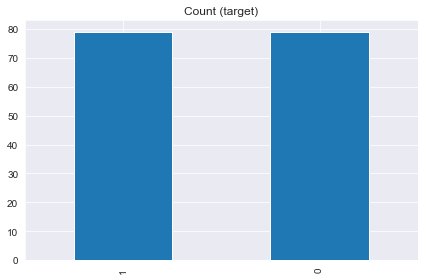

In [1461]:
# Class count
count_class_0, count_class_1 = full_train_model["heart_disease_present"].value_counts()

# upsampling
# Divide by class
df_class_0 = full_train_model[full_train_model["heart_disease_present"] == 0]
df_class_1 = full_train_model[full_train_model["heart_disease_present"] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under["heart_disease_present"].value_counts())

df_test_under["heart_disease_present"].value_counts().plot(kind='bar', title='Count (target)');

df_train = df_test_under

In [1462]:
df_train["heart_disease_present"].value_counts()

1    79
0    79
Name: heart_disease_present, dtype: int64

In [1463]:
df_train.head()

,resting_blood_pressure,num_major_vessels,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present,slope_2,slope_3,thal_normal,thal_reversible_defect,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,blood_sugar_1,resting_ekg_1,resting_ekg_2
72,5.147494,0,5.293305,0.707107,1,52,162,0,0,0,0,0,1,0,1,0,1,0,0
104,4.941642,0,5.746203,0.447214,0,64,133,0,0,0,0,0,1,0,1,0,0,0,0
116,4.905275,0,5.313206,0.000000,1,41,132,0,0,1,0,0,0,1,0,0,0,0,0
64,4.700480,0,5.537334,0.000000,0,50,159,0,0,0,0,1,0,0,0,1,0,0,1
169,4.700480,0,5.351858,1.341641,1,64,144,1,0,1,0,1,0,0,0,0,0,0,1


In [1464]:
len(df_train)

158

### Understanding Feature Importance

In [1465]:
# #pca = PCA()
# #fit = pca.fit(df_train)
# #plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Variance (%)') #for each component
# plt.title('Pulsar Dataset Explained Variance')
# plt.show()

In [1466]:
# pca = PCA(n_components=5)
# fit = pca.fit(df_train)
# print(("{} Components \nExplained Variance: {}\n").format("5", fit.explained_variance_ratio_))

### Split into Training and Testing (Validation) Set

In [1467]:
df_train.head()

,resting_blood_pressure,num_major_vessels,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present,slope_2,slope_3,thal_normal,thal_reversible_defect,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,blood_sugar_1,resting_ekg_1,resting_ekg_2
72,5.147494,0,5.293305,0.707107,1,52,162,0,0,0,0,0,1,0,1,0,1,0,0
104,4.941642,0,5.746203,0.447214,0,64,133,0,0,0,0,0,1,0,1,0,0,0,0
116,4.905275,0,5.313206,0.000000,1,41,132,0,0,1,0,0,0,1,0,0,0,0,0
64,4.700480,0,5.537334,0.000000,0,50,159,0,0,0,0,1,0,0,0,1,0,0,1
169,4.700480,0,5.351858,1.341641,1,64,144,1,0,1,0,1,0,0,0,0,0,0,1


In [1468]:
# numerical
df_train_numerical = df_train.loc[:,["resting_blood_pressure", "num_major_vessels", "serum_cholesterol_mg_per_dl",
                                        "oldpeak_eq_st_depression", "age", "max_heart_rate_achieved"]]

# categorical
df_train_categorical = df_train.loc[:,["sex", "exercise_induced_angina", "slope_2", "slope_3", "thal_normal",
                                          "thal_reversible_defect", "chest_pain_type_2", "chest_pain_type_3", 
                                          "chest_pain_type_4", "blood_sugar_1", "resting_ekg_1", 
                                          "resting_ekg_2"]]

In [1469]:
X = df_train.drop(["heart_disease_present"],axis=1)

In [1470]:
y = df_train["heart_disease_present"]

In [1471]:
# Stratified Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testset_size, stratify=y, random_state=rstate)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Stratified Cross-Validation
cv = StratifiedShuffleSplit(n_splits = n_splits, test_size=0.2, random_state=rstate)

In [1472]:
cv

StratifiedShuffleSplit(n_splits=5, random_state=101, test_size=0.2,
            train_size=None)

In [1473]:
X_train.shape

(126, 18)

In [1474]:
X_test.shape

(32, 18)

In [1475]:
y_train.shape

(126,)

In [1476]:
y_test.shape

(32,)

In [1477]:
y_train = y_train.astype('int')

In [1478]:
y_test = y_test.astype("int")

### Standardizing

In [1479]:
sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(sc.transform(X_test), index=X_test.index, columns=X_test.columns)

### Storage for model and results

In [1480]:
# Storage for Model and Results
results = pd.DataFrame(columns=['Model','Para','Test_Score','CV Mean','CV STDEV'])
ensemble_models= {}

In [1481]:
# Compute, Print, and Save Model Evaluation
def save(model, modelname):
    """
    This function saves the cross-validation and held-out (Test set) accuracy scores
    as well as their sd to the "results" dataframe. Then it executes the model prediction
    on the submission set. Finally, it outputs a confusion matrix of the test set.
    
    Function Arguments:
    model - the sklearn randomized/grid searchCV model
    modelname - string of the model name for saving purposes/
    """
    global results
    # once best model is found, establish more evaluation metrics
    model.best_estimator_.fit(X_train_scaled, y_train)
    scores = cross_val_score(model.best_estimator_, X_train_scaled, y_train, cv=5, scoring=scoring, verbose=0)
    CV_scores = scores.mean()
    STDev = scores.std()
    Test_scores = model.score(X_test_scaled, y_test)
    
    # CV and save scores
    results = results.append({"Model": modelname,
                              "Params": model.best_params_,
                              "Test_Score": Test_scores,
                              "CV Mean": CV_scores,
                              "CV STDEV": STDev}, ignore_index=True)
    ensemble_models[modelname] = model.best_estimator_
    
    # print evaluation
    print("\nEvaluation Method: {}".format(scoring))
    print("Optimal Model Parameters: {}".format(grid.best_params_))
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" %(CV_scores, STDev, modelname))
    print("Test_Score:", Test_scores)
    
    # scikit confusion matrix
    model.best_estimator_.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)
    skplt.metrics.plot_confusion_matrix(y_test, pred, title="{} Confusion Matrix".format(modelname), normalize=True,
    figsize=(6,6), text_fontsize="large")
    plt.show()

In [1482]:
def norm_save(model,score, modelname):
    global results
    model.fit(X_train_scaled, y_train)
    submission = model.predict(test_model)
    df = pd.DataFrame({"Patient ID": test.index,
                      "heart_disease_present": submission})
    
    CV_Scores = score.mean()
    Test_scores = model.score(X_test_scaled, y_test)
    STDev = score.std()
    
    # CV and Save Scores
    Test_Score = model.score(X_test_scaled, y_test)
    results = results.append({"Model": modelname, 
                             "Params": model,
                             "Test_Score":Test_scores,
                             "CV Mean": CV_Scores,
                             "CV STDEV": STDev}, ignore_index=True)
    ensemble_models[modelname] = model
        
        
    print("\nEvaluation Method: {}".format(scoring))
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" %(CV_Scores, STDev, modelname))
    print("Test_Score:", Test_scores)
    
    # Scikit confusion matrix
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)
    skplt.metrics.plot_confusion_matrix(y_test, pred, title="{} Confusion Matrix".format(modelname),
                                        normalize=True,figsize=(6,6),text_fontsize='large')
    plt.show()

In [1483]:
# ROC curve plot
def eval_plot(model):
    skplt.metrics.plot_roc_curve(y_test, model.predict_proba(X_test_scaled))
    plt.show()

## 6. Non-Parametric Models

### K-Nearest Neighbors

A nonparametric method that works well on short and narrow datasets but struggles in high dimensional space

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.0s finished



Evaluation Method: accuracy
Optimal Model Parameters: {'n_neighbors': 8, 'weights': 'uniform'}
Train CV Accuracy: 0.85 (+/- 0.02) [KNN]
Test_Score: 0.8125


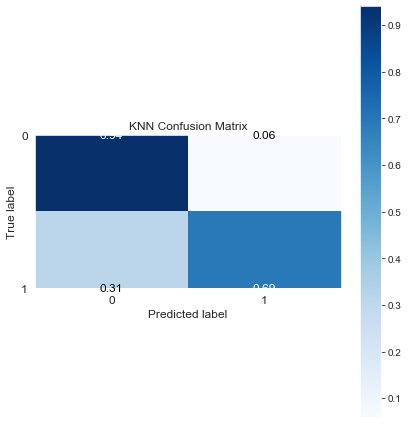

In [1484]:
# hyperparameters
param_grid = {"n_neighbors": st.randint(1,40),
             # increase this value reduces bias and increase variance. important not to overfit it
             "weights":["uniform", "distance"]}

# hyperparameters tuning with cross-validation
grid = RandomizedSearchCV(KNeighborsClassifier(),
                         param_grid,
                         cv=cv,
                         scoring=scoring, #best validation selection metric
                         verbose=1,
                         n_iter=n_iter, #no. of hyperparameter combinations tried
                         random_state=rstate)

# execute tuning on entire dataset
grid.fit(X_train_scaled, y_train)
save(grid, "KNN")

### Stochastic Gradient Descent

In [1485]:
SGDClassifier().get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])


Evaluation Method: accuracy
Optimal Model Parameters: {'loss': 'hinge'}
Train CV Accuracy: 0.79 (+/- 0.05) [StochasticGradientDescent]
Test_Score: 0.75


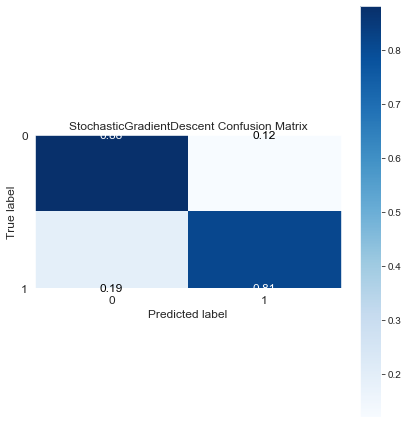

In [1486]:
param_grid = {"loss":["hinge", "log", "modified_huber","epsilon_insensitive", "squared_epsilon_insensitive"]}

grid = GridSearchCV(SGDClassifier(max_iter=5, tol=None), param_grid, cv=cv, scoring=scoring)
grid.fit(X_train_scaled, y_train)
save(grid, "StochasticGradientDescent")

### Decision Trees

In [1487]:
# helper function to visualize feature importance
plt.rcParams["figure.figsize"] = (15,7)
predictors = [x for x in X.columns if x not in ["heart_disease_present"]]

def feature_imp(model):
    MO = model.fit(X_train_scaled, y_train)
    feat_imp = pd.Series(MO.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel("Feature Importance Score")

In [1488]:
DecisionTreeClassifier().get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [1489]:
y = y.astype("int")

Mean CV Accuracy: 0.74375


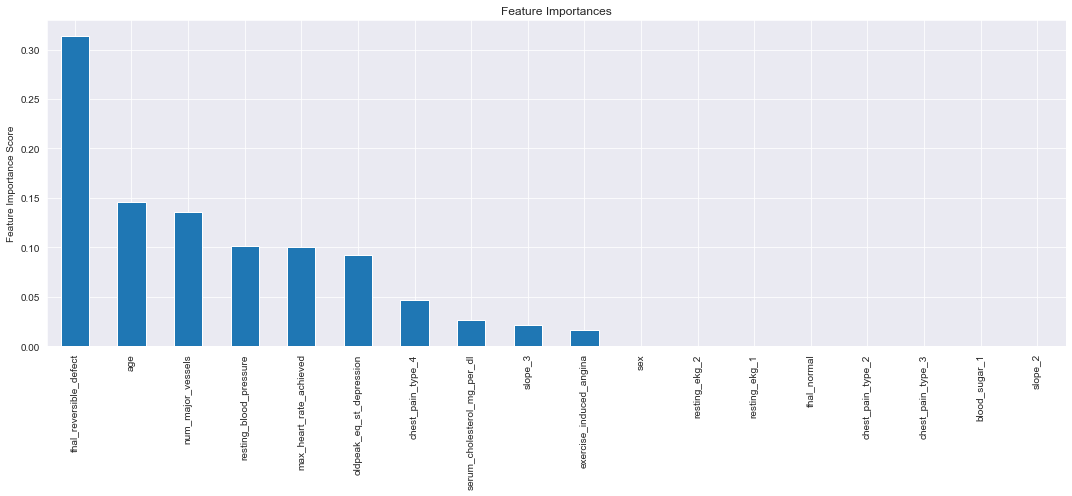

In [1490]:
# baseline decision tree
tree = DecisionTreeClassifier()
print("Mean CV Accuracy:", cross_val_score(tree, X, y, cv=cv, scoring=scoring).mean())
feature_imp(tree)

In [1491]:
df_train.columns

Index(['resting_blood_pressure', 'num_major_vessels',
       'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'sex', 'age',
       'max_heart_rate_achieved', 'exercise_induced_angina',
       'heart_disease_present', 'slope_2', 'slope_3', 'thal_normal',
       'thal_reversible_defect', 'chest_pain_type_2', 'chest_pain_type_3',
       'chest_pain_type_4', 'blood_sugar_1', 'resting_ekg_1', 'resting_ekg_2'],
      dtype='object')

f, ax = plt.subpl ots(figsize=(6,4))
s = sns.heatmap(pd.crosstab(df_train["sex"], df_train["num_major_vessels"]), 
                annot=True, 
                fmt="d", 
                linewidths=0.5, 
                ax=ax, 
                cmap="plasma",
                cbar_kws={"label": "Count"})
s.set_title("Num Major Vessels by Sex Crosstab Heatmap")
plt.show()

### Ensemble Methods for Decision Trees

max_features: This is the random subset of features to be considered for splitting operation. The lower the better to reduce variance. For classification model, ideal max_features = sqrt(n_var).     
max_depth: Maximum depth of the tree. Alternate method of control model depth is max_leaf_nodes, which limits the number of terminal nodes, effectively limiting the depth of the tree.    
n_estimators: Number of trees built before average prediction is made.   
min_samples_split: Minimum number of samples required for a node to be split. Small minimum would potentially lead to a Bushy Tree which is prone to overfitting. According to Analytics Vidhya, should be around 0.5~1% of the datasize.   
min_samples_leaf: Minimum number of samples required at the terminal node of the tree.   
random_state = Ensuring consistency random generation. Important to consider for comparing models of the same type to ensure a fair comparison. May cause overfitting if random generation is not representative.

### Bagging

Creating a bunch of trees using a subset of the data while using sampling without replacement (values may be sampled multiple times)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.4min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'n_estimators': 176}
Train CV Accuracy: 0.78 (+/- 0.12) [Bagging]
Test_Score: 0.78125


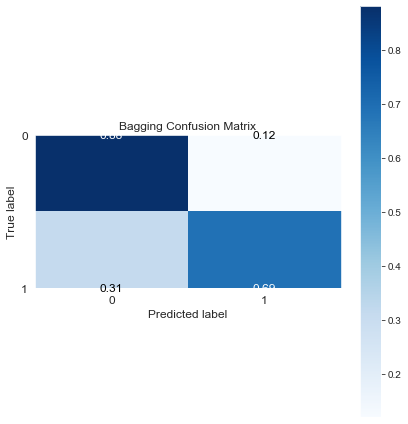

In [1492]:
# parameter tuning
param_grid = {"n_estimators": n_tree_range}
tree = DecisionTreeClassifier()
grid = RandomizedSearchCV(BaggingClassifier(tree),
                         param_grid,
                         cv=cv,
                         scoring=scoring,
                         verbose=1,
                         n_iter=n_iter,
                         random_state=rstate)

grid.fit(X_train_scaled, y_train)
save(grid, "Bagging")

### Random Forest

Mean CV Accuracy: 0.8125


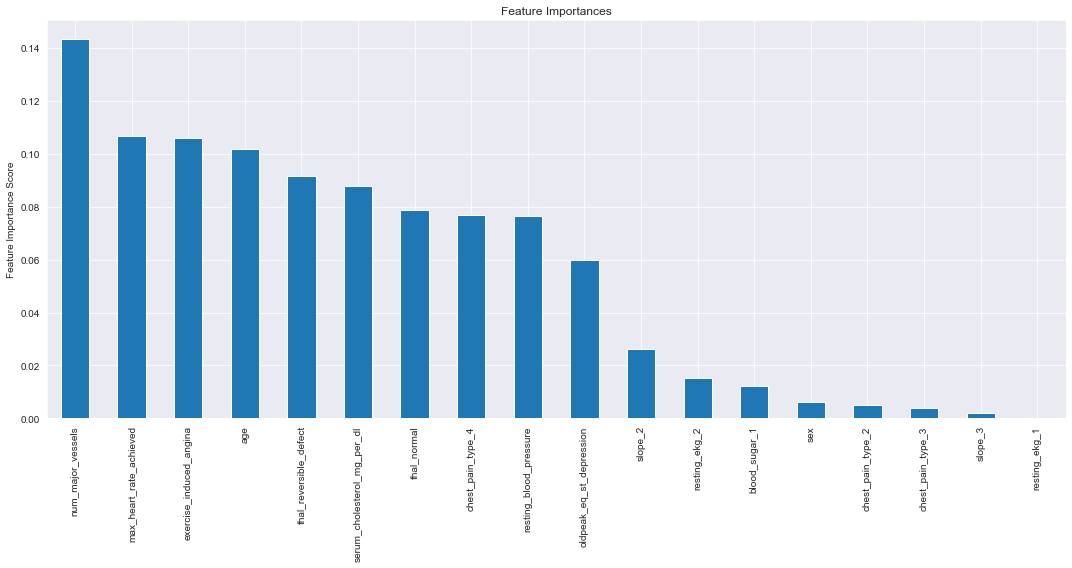

In [1493]:
model = RandomForestClassifier()
print("Mean CV Accuracy:", cross_val_score(model, X, y, cv=cv, scoring=scoring).mean())
plt.figure(figsize=(15,8))
feature_imp(model)

In [1494]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.5min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': 6, 'n_estimators': 300}
Train CV Accuracy: 0.83 (+/- 0.03) [Random_Forest]
Test_Score: 0.75


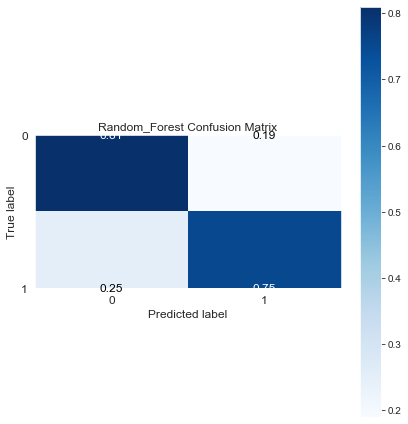

In [1495]:
param_grid={"max_depth": st.randint(3,11),
            "max_features":["sqrt", "log2"],
            'n_estimators':[100, 200, 300, 400, 500],
            "max_leaf_nodes": st.randint(6, 10)
}

model = RandomForestClassifier()

grid = RandomizedSearchCV(model, 
                         param_grid, 
                         cv=cv,
                         scoring=scoring,
                         verbose=1,
                         n_iter=n_iter,
                         random_state=rstate)

grid.fit(X_train_scaled, y_train)
save(grid, "Random_Forest")

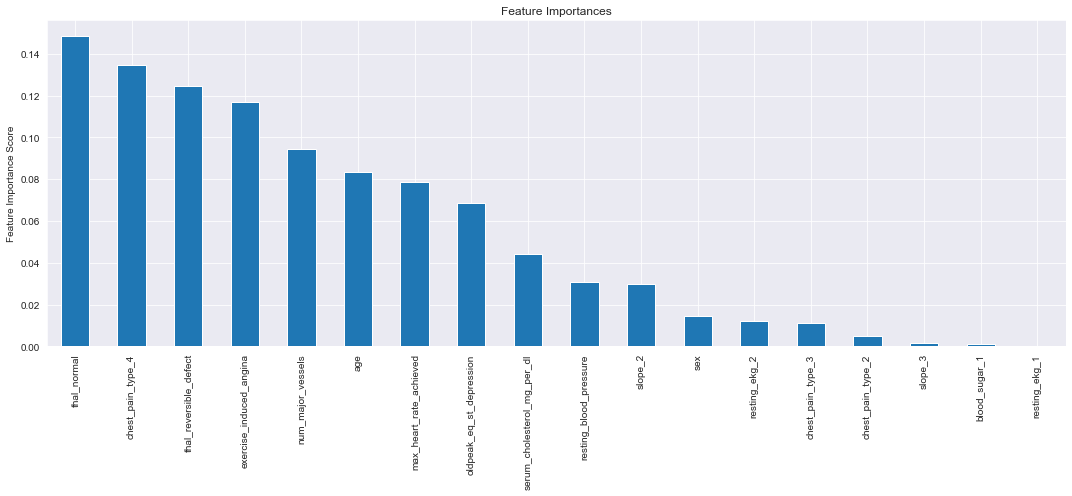

In [1496]:
plt.figure(figsize=(15,7))
feature_imp(grid.best_estimator_)

### Boosting Family

Each weak model is trained on a different distribution of the data, enabling it to learn a narrow rule. When combined it offers a stronger model.

### Adaptive Boosting

Applies weights to all data points and optimizes them using the loss function. Fixes mistakes by assigning high weights to them during iterative process. Iterates through multiple models in order to determine the best boundaries. It relies on using weak model to determine the pattern and eventually creates a strong combination of them.

In [1497]:
# see the parameters used
AdaBoostClassifier().get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.9min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'learning_rate': 0.1, 'n_estimators': 416}
Train CV Accuracy: 0.80 (+/- 0.07) [AdaBoost]
Test_Score: 0.78125


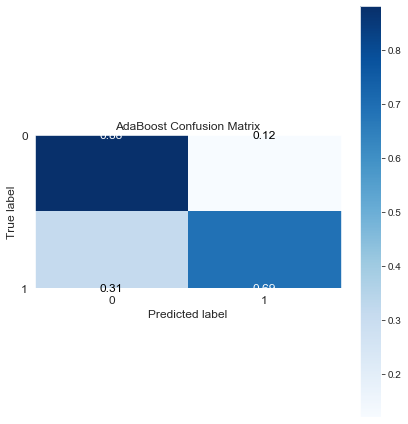

In [1498]:
# set the parameter grid
param_grid = {"n_estimators": n_tree_range, 
             "learning_rate": np.arange(0.1, 4, 0.5)}

grid = RandomizedSearchCV(AdaBoostClassifier(),
                         param_grid,
                         cv=cv,
                         scoring=scoring,
                         verbose=1,
                         n_iter=n_iter,
                         random_state=rstate)

grid.fit(X_train_scaled, y_train)
save(grid, "AdaBoost")

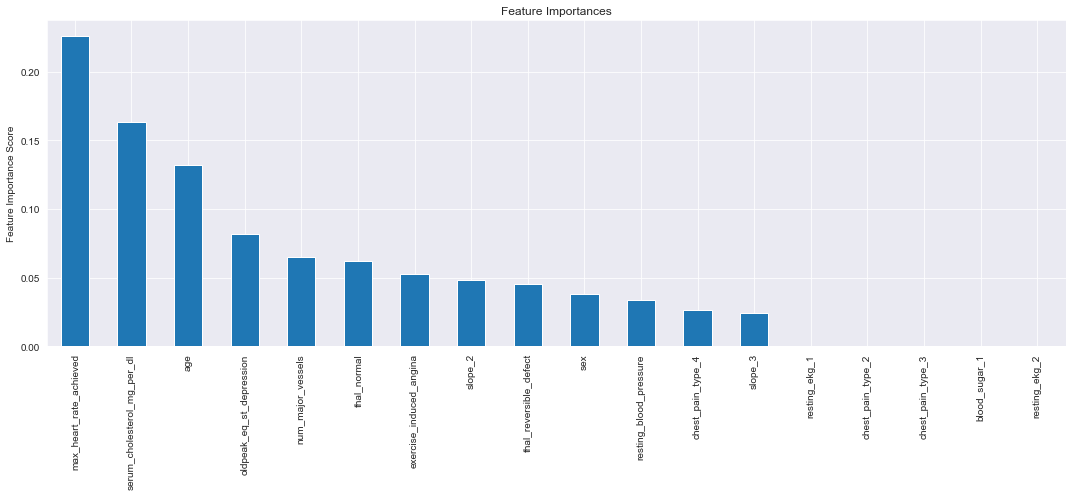

In [1499]:
plt.figure(figsize=(15,7))
feature_imp(grid.best_estimator_)

### Gradient Boosting Classifier

In [1500]:
GradientBoostingClassifier().get_params().keys()

dict_keys(['criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.5min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 303}
Train CV Accuracy: 0.71 (+/- 0.07) [Gradient_Boosting]
Test_Score: 0.75


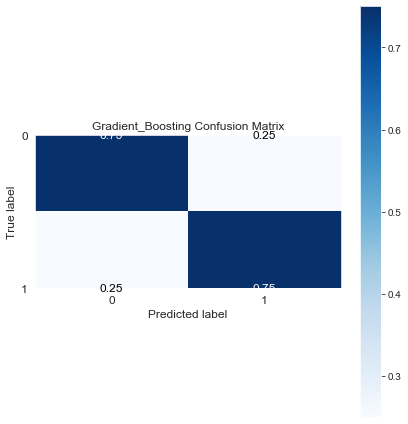

In [1501]:
# set parameter grid
param_grid = {"n_estimators": n_tree_range,
              "loss" : ["deviance", "exponential"],
              "learning_rate": [0.1, 0.01, 0.05, 0.001],
              "max_depth": np.arange(2, 12, 1)}

grid = RandomizedSearchCV(GradientBoostingClassifier(),
                         param_grid,
                         cv=cv,
                         scoring=scoring,
                         verbose=1,
                         n_iter=n_iter,
                         random_state=rstate)

grid.fit(X_train_scaled, y_train)
save(grid, "Gradient_Boosting")

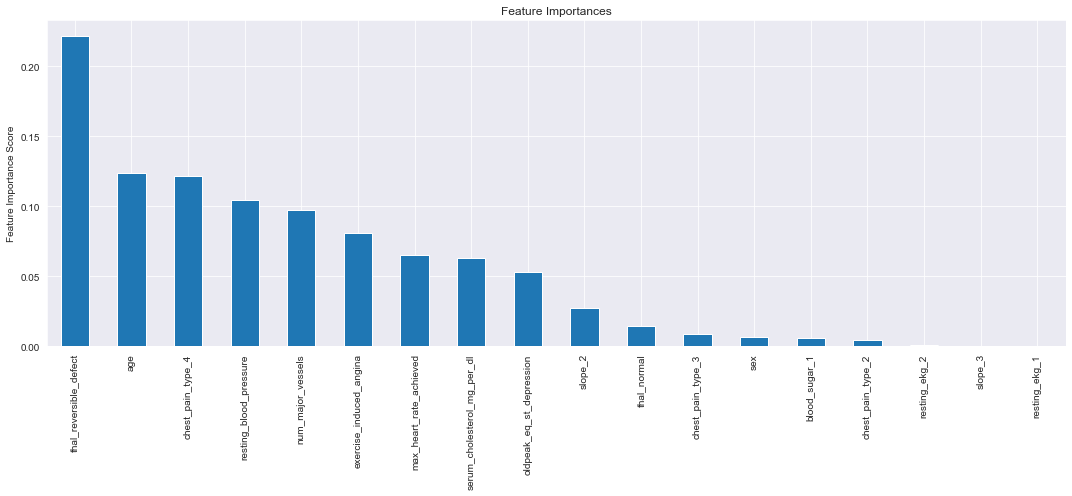

In [1502]:
plt.figure(figsize=(15,7))
feature_imp(grid.best_estimator_)

 ### XGBoost

XGBoost is able to approximate the Loss function more efficiently hence leading to a faster computation and parallel processing. Its objective function also incorporated a regularization term, ridge or lasso to stay clear of high dimensional spaces and complexity

In [1503]:
XGBClassifier().get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   20.6s finished



Evaluation Method: accuracy
Optimal Model Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 723}
Train CV Accuracy: 0.80 (+/- 0.04) [XGBoost]
Test_Score: 0.78125


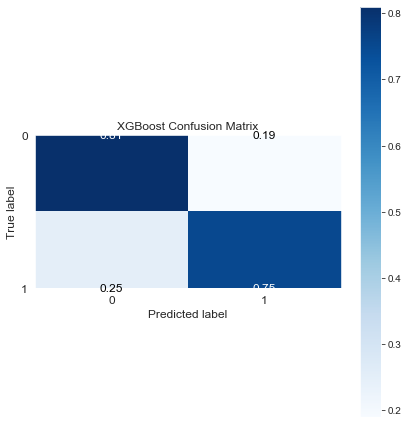

In [1504]:
# setting parameters
params = {"n_estimators": n_tree_range,
         "max_depth": st.randint(3,15),
         "learning_rate":[0.05]}

xgbreg = XGBClassifier(objective = "binary:logistic", 
                      eval_metric="auc",
                      nthreads=2)

grid = RandomizedSearchCV(xgbreg, params, n_jobs=1, verbose=1, n_iter=n_iter,
                         random_state=rstate, scoring=scoring)

grid.fit(X_train_scaled, y_train, verbose=False)
save(grid, "XGBoost")

### XGBoost Native

In [1505]:
xgtrain = xgb.DMatrix(X_train_scaled, label=y_train)
xgtest = xgb.DMatrix(X_test_scaled, label=y_test)
xgtesting = xgb.DMatrix(test_model)

In [1506]:
# set xgboost params
param = {"eta":0.05,
        "max_depth":8,
        "subsample":0.8,
        "colsample_bytree":0.75,
        "min_child_weight":1.5,
        "objective":"binary:logistic",
        "eval_metric":"logloss",
        "seed":23,
        "lambda":1.5,
        "alpha":0.6}

In [1507]:
clf_xgb_cv = xgb.cv(param, xgtrain, num_rounds, stratified=True,
                   nfold=n_splits,
                   early_stopping_rounds=50,
                   verbose_eval=20)

[0]	train-logloss:0.673699+0.000253074	test-logloss:0.677331+0.00332909
[20]	train-logloss:0.445682+0.00850826	test-logloss:0.505714+0.0239218
[40]	train-logloss:0.341972+0.0107665	test-logloss:0.442579+0.035855
[60]	train-logloss:0.287651+0.0120409	test-logloss:0.410369+0.0473854
[80]	train-logloss:0.251698+0.011663	test-logloss:0.398001+0.0547313
[100]	train-logloss:0.226605+0.0111657	test-logloss:0.392534+0.0629991
[120]	train-logloss:0.208008+0.0113591	test-logloss:0.387848+0.0656418
[140]	train-logloss:0.192875+0.0102878	test-logloss:0.391656+0.0712245
[160]	train-logloss:0.180122+0.00963779	test-logloss:0.394934+0.0731622


In [1508]:
print("Optimal number of trees/estimators is %i" %clf_xgb_cv.shape[0])

Optimal number of trees/estimators is 130


In [1509]:
watchlist = [(xgtrain, "train"), (xgtest, "test")]

In [1510]:
clf_xgb = xgb.train(param, xgtrain, clf_xgb_cv.shape[0], watchlist, verbose_eval=0)

In [1511]:
# best cutoff threshold
p = clf_xgb.predict(xgtest)
fpr, tpr, thresholds = metrics.roc_curve(y_test, p)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("\nOptimal Threshold: ", optimal_threshold)


Optimal Threshold:  0.46743482


In [1512]:
# use 0.6 cutoff to convert proability to class label
y_train_pred = (clf_xgb.predict(xgtrain, ntree_limit=clf_xgb.best_iteration) > optimal_threshold).astype(int)
y_test_pred = (clf_xgb.predict(xgtest, ntree_limit=clf_xgb.best_iteration) > optimal_threshold).astype(int)
score = metrics.accuracy_score(y_test_pred, y_test)
print("\nXGB - CV Train : %.2f" % score)
train_score = metrics.accuracy_score(y_train_pred, y_train)
print("XGB - Train : %.2f" % train_score)


XGB - CV Train : 0.81
XGB - Train : 0.94


In [1513]:
results = results.append({"Model": "BESTXGBOOST", 
                          "Para":param, 
                          "Test_Score":score, 
                          "CV Mean": train_score,
                          "CV STDEV": None}, ignore_index=True)

In [1514]:
xgboostprobpred = clf_xgb.predict(xgtesting, ntree_limit=clf_xgb.best_iteration)
xgboostpred = (xgboostprobpred > optimal_threshold).astype(int)
submission = pd.DataFrame({"Patient ID":test["patient_id"], "heart_disease_present":xgboostpred})
submission.to_csv("BESTXGBOOST.csv", index=False)

### Light Gradient Boosting

In [1515]:
lgtrain = lgb.Dataset(X_train_scaled, y_train, categorical_feature = categorical_features, free_raw_data=False)

In [1516]:
lgvalid = lgb.Dataset(X_test_scaled, y_test, categorical_feature = categorical_features, free_raw_data=False)

In [1517]:
lgbm_params = {"boosting_type": "gbdt",
               "objective": "binary",
               "metric": "auc",
               "max_depth": 12,
               #"num_leaves": 500,
               "learning_rate": 0.01,
               "feature_fraction": 0.80,
               "bagging_freq": 5,
               "max_bin": 300,
               #"verbose":0,
               #"num_threads":1,
               "lambda_l2": 1.5,
               #"min_gain_to_split":0,
               "is_unbalance":True,
               #"scale_pos_weight":0.15
              }

modelstart = time.time()
lgb_clf = lgb.train(lgbm_params,
                    lgtrain,
                    num_boost_round=num_rounds,
                    valid_sets=[lgtrain, lgvalid],
                    valid_names=["train", "valid"],
                    early_stopping_rounds=50,
                    verbose_eval=50)

print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.943815	valid's auc: 0.822266
[100]	train's auc: 0.952003	valid's auc: 0.851562
[150]	train's auc: 0.958428	valid's auc: 0.878906
[200]	train's auc: 0.962711	valid's auc: 0.875
Early stopping, best iteration is:
[165]	train's auc: 0.959688	valid's auc: 0.882812

Model Runtime: 0.00 Minutes


In [1518]:
# Best cutoff threshold
p = lgb_clf.predict(X_test_scaled)
fpr, tpr, thresholds = metrics.roc_curve(y_test, p)

In [1519]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold: ", optimal_threshold)

Optimal Threshold:  0.4792689250157127


In [1520]:
# so we will use 0.5 cutoff to convert probability to class label
y_train_pred = (lgb_clf.predict(X_train_scaled) > optimal_threshold).astype(int)
y_test_pred = (lgb_clf.predict(X_test_scaled) > optimal_threshold).astype(int)

score = metrics.accuracy_score(y_test_pred, y_test)
print("\nXGB - CV Train : %.2f" % score)
train_score = metrics.accuracy_score(y_train_pred, y_train)
print("XGB - Train : %.2f" % train_score)


XGB - CV Train : 0.78
XGB - Train : 0.88


In [1521]:
# save
results = results.append({"Model": "LGBM", 
                         "Para": lgbm_params,
                         "Test_Score": score,
                         "CV Mean": train_score,
                         "CV STDEV": None}, ignore_index=True)

In [1522]:
lgbmprobpred = lgb_clf.predict(test_model)
lgbmpred = (lgbmprobpred > optimal_threshold).astype(int)
submission = pd.DataFrame({"Patient ID": test["patient_id"], "heart_disease_present":lgbmpred})
submission.to_csv("LGBM.csv", index=False)

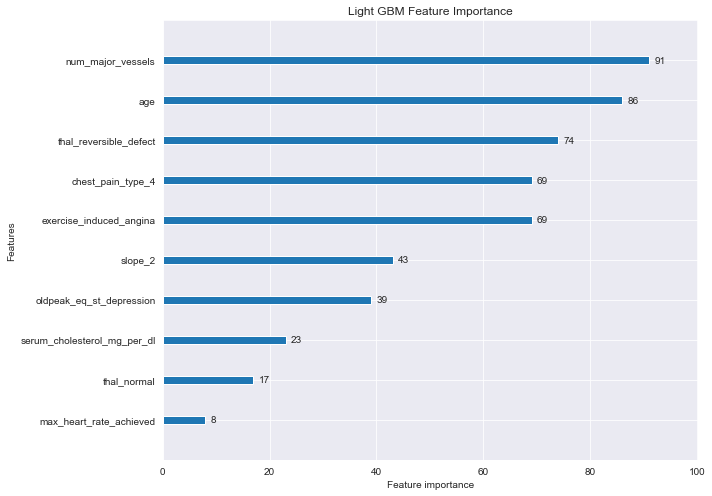

In [1523]:
f, ax = plt.subplots(figsize=[10,7])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.show()

### Gradient Boost Blend

In [1524]:
# Simple Mode Blend
modeblend = pd.DataFrame([xgboostpred, lgbmpred, lgbmpred]).T
modeblend.head()
modeblend["Mode"] = modeblend.mode(axis=1)
submission = pd.DataFrame({"Patient ID": test["patient_id"], "heart_disease_present":modeblend["Mode"]})
submission.to_csv("C:\\Users\\joann\\OneDrive\\Desktop\\My Files\\Data Science\\Predicting Heart Disease\\Mode_GBM_Blend.csv", index=False)
submission.head()

,Patient ID,heart_disease_present
0,olalu7,1
1,z9n6mx,0
2,5k4413,1
3,mrg7q5,1
4,uki4do,1


In [1525]:
# Mean Blend
predblend = pd.DataFrame(np.array([xgboostprobpred, lgbmprobpred, lgbmpred])).T
predblend.columns = ["XG", "LGBM", "CAT"]
predblend["meanblend"] = predblend.mean(axis=1)
predblend["blendout"] = (predblend["meanblend"] > 0.5).astype(int)
submission = pd.DataFrame({"Patient ID": test["patient_id"], "heart_disease_present":predblend["blendout"]})
submission.to_csv("C:\\Users\\joann\\OneDrive\\Desktop\\My Files\\Data Science\\Predicting Heart Disease\\mean_GBM_blend.csv", index=False)
submission.head()

,Patient ID,heart_disease_present
0,olalu7,1
1,z9n6mx,0
2,5k4413,1
3,mrg7q5,1
4,uki4do,1


## 7. Parametric Models

Family of models which makes assumption of the underlying distribution and attempts to build models on top of it with a fixed number of parameters. Works great when the assumption is correct and the data behaves itself.

### Logistic Regression

In [1526]:
# stratified cross-validation
cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=rstate)


Evaluation Method: accuracy
Train CV Accuracy: 0.79 (+/- 0.03) [Logistic_Regression]
Test_Score: 0.75


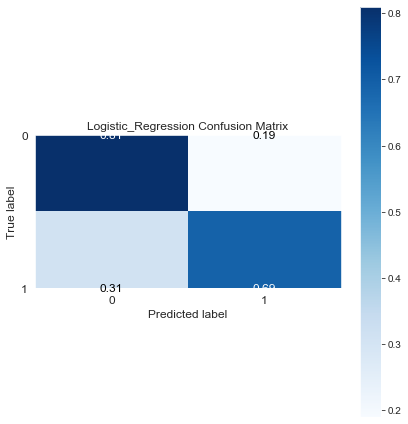

In [1527]:
model = LogisticRegression()
score = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="accuracy")
norm_save(LogisticRegression(), score, "Logistic_Regression")

### Feedforward Neural Network

In [1528]:
MLPClassifier().get_params().keys()

dict_keys(['activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_iter', 'momentum', 'n_iter_no_change', 'nesterovs_momentum', 'power_t', 'random_state', 'shuffle', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [1529]:
# start with a RandomSearchCV to efficiently narrow the ballpark
param_grid = {"max_iter": np.logspace(1, 5, 10).astype("int32"),
             "hidden_layer_sizes": np.logspace(2, 3, 4).astype("int32"),
             "activation": ["identity", "logistic", "tanh", "relu"],
             "learning_rate": ["adaptive"],
             "early_stopping": [True],
             "alpha": np.logspace(2, 3, 4).astype("int32")}

In [1530]:
model = MLPClassifier()
grid = RandomizedSearchCV(model, param_grid, cv=cv, scoring=scoring, verbose=1, n_iter=n_iter, random_state=rstate)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   10.1s finished



Evaluation Method: accuracy
Optimal Model Parameters: {'max_iter': 77, 'learning_rate': 'adaptive', 'hidden_layer_sizes': 1000, 'early_stopping': True, 'alpha': 100, 'activation': 'identity'}
Train CV Accuracy: 0.70 (+/- 0.16) [FFNeural_Net]
Test_Score: 0.65625


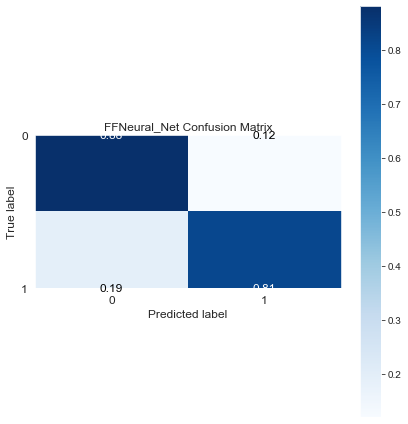

In [1531]:
grid.fit(X_train_scaled, y_train)
save(grid, "FFNeural_Net")

### Support Vector Classifier

#### Linear Classifier

Hyperparameters   
C: Rigidity and size of the separation line margin. Increasing C leads to a small, thus a more complex model and everything that comes with it (High variance, Low Bias)


Evaluation Method: accuracy
Train CV Accuracy: 0.79 (+/- 0.08) [LinearSV]
Test_Score: 0.75


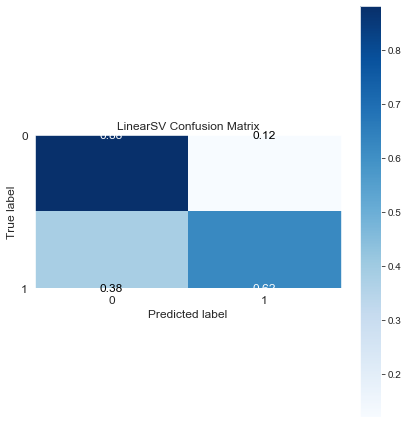

In [1532]:
# parameters
LinearSVC().get_params().keys()

# define model
model = LinearSVC()

# fit model
scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring=scoring)
norm_save(model, scores, "LinearSV")

#### Radial Basis Function

Hyperparameters   
Gamma: How far the influence of a single training example reaches anad sort of like a soft boundary with a gradient.    
Low gamma = distant fit, High gamma = close fit.

In [1533]:
SVC().get_params().keys()

dict_keys(['C', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [1534]:
# define model
svc = SVC(kernel = "rbf", probability=True)
model = Pipeline(steps=[("svc", svc)])

In [1535]:
param_grid = {"svc__C": st.randint(1, 10000),
              "svc__gamma": np.logspace(1, -7, 10)}

grid = RandomizedSearchCV(model, param_grid, cv=cv, verbose=1, scoring=scoring, n_iter=n_iter, random_state=rstate)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.1s finished



Evaluation Method: accuracy
Optimal Model Parameters: {'svc__C': 6142, 'svc__gamma': 1e-07}
Train CV Accuracy: 0.85 (+/- 0.04) [SVCrbf]
Test_Score: 0.78125


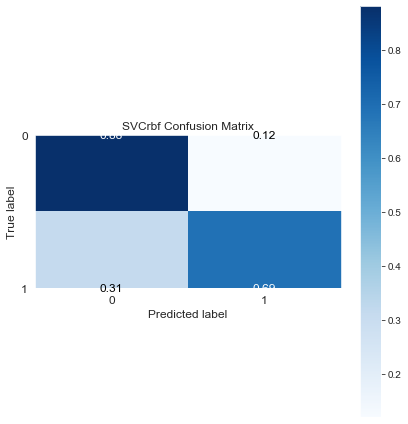

In [1536]:
grid.fit(X_train_scaled, y_train)
save(grid, "SVCrbf")

### Dimensonality Reduction: PCA

Decreases the noise by condensing the features into the dimensions of most variance

In [1537]:
pca = PCA()
svc = SVC(kernel = "rbf", probability=True)

model = Pipeline(steps = [("pca", pca),
                         ("svc", svc)])

param_grid = {"svc__C": st.randint(1, 10000),
              "svc__gamma": np.logspace(1, -7, 10),
              "pca__n_components": st.randint(1, len(X.columns))}

grid = RandomizedSearchCV(model, param_grid, cv=cv, verbose=1, n_iter=n_iter, random_state=rstate, scoring=scoring)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    4.0s finished



Evaluation Method: accuracy
Optimal Model Parameters: {'pca__n_components': 5, 'svc__C': 5076, 'svc__gamma': 0.021544346900318846}
Train CV Accuracy: 0.74 (+/- 0.06) [PCA_SVC]
Test_Score: 0.65625


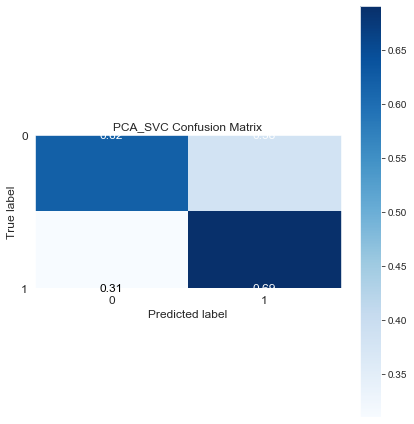

In [1538]:
grid.fit(X_train_scaled, y_train)
save(grid, "PCA_SVC")

## 8. Parametric Generative Classification

Process is represeted in terms of join probabilities. Advantageous since it can be used to generate features but tends to struggle in terms of accuracy and doesn't scale well into tall and wide datasets. Only Gaussian Bayes is used here but additional generative models can be explored such as:   
Hidden Markov model   
Latent Dirichlet Allocation   
Restricted Boltzmann machine    
Generative adversarial networks

### Gaussian Naive Bayes

Uses conditional probabilities to classify data. Predicts the class by finding the one with the highest Posterior


Evaluation Method: accuracy
Train CV Accuracy: 0.82 (+/- 0.04) [Gaussian]
Test_Score: 0.84375


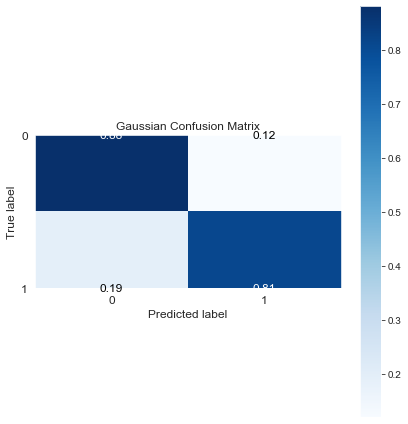

In [1539]:
model = GaussianNB()
score = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring=scoring)
norm_save(model, score, "Gaussian")

In [1540]:
results.sort_values(by=["Test_Score"], ascending=False, inplace=True)
results

,Model,Para,Test_Score,CV Mean,CV STDEV,Params
14,Gaussian,NaN,0.84375,0.815385,0.0448535,"GaussianNB(priors=None, var_smoothing=1e-09)"
0,KNN,NaN,0.81250,0.850000,0.0247771,"{'n_neighbors': 8, 'weights': 'uniform'}"
7,BESTXGBOOST,"{'eta': 0.05, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.75, 'min_child_weight': 1.5, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'seed': 23, 'lambda': 1.5, 'alpha': 0.6}",0.81250,0.944444,None,NaN
2,Bagging,NaN,0.78125,0.775641,0.119702,{'n_estimators': 176}
4,AdaBoost,NaN,0.78125,0.801282,0.0679306,"{'learning_rate': 0.1, 'n_estimators': 416}"
6,XGBoost,NaN,0.78125,0.802564,0.0390237,"{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 723}"
8,LGBM,"{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'max_depth': 12, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'bagging_freq': 5, 'max_bin': 300, 'lambda_l2': 1.5, 'is_unbalance': True}",0.78125,0.880952,None,NaN
12,SVCrbf,NaN,0.78125,0.850000,0.0361711,"{'svc__C': 6142, 'svc__gamma': 1e-07}"
1,StochasticGradientDescent,NaN,0.75000,0.793590,0.0506613,{'loss': 'hinge'}
3,Random_Forest,NaN,0.75000,0.833333,0.0298611,"{'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': 6, 'n_estimators': 300}"


## 9. Classification Voting: Model Ensemble

This system brings together models of all types.   
Hard Voting: Plurality voting over the classes.   
Soft Voting: Selects classed based off aggregated probabilities over the models. Requires model with probabilistic capabilities.   
Weights: An additional feature which emables manual assigning voting power to each voting model.

#### Setting up

In [1541]:
# Ensemble Voting
ignore = ["BESTXGBOOST", "LGBM", "Logistic GAM"]
not_proba_list = ["LinearSV", "StochasticGradientDescent"]
not_proba = results.query("Model in @not_proba_list")
hard_models = results.query("Model not in @ignore")
prob_models = results.query("Model not in @not_proba_list & Model not in @ignore")

# submission dataframe for correlation purposes
# hard output
test_hard_pred_matrix = pd.DataFrame()
train_hard_pred_matrix = pd.DataFrame()
valid_hard_pred_matrix = pd.DataFrame()

# soft output
test_soft_pred_matrix = pd.DataFrame()
train_soft_pred_matrix = pd.DataFrame()
valid_soft_pred_matrix = pd.DataFrame()


#### Class predictions

In [1542]:
# only non-probabilistic
models = list(zip([ensemble_models[x] for x in not_proba.Model], not_proba.Model))
clfs = []

print("5-fold cross validation:\n")
for clf, label in models:
    scores = cross_val_score(clf, X_train_scaled, y_train, cv=cv, scoring=scoring, verbose=0)
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" %(scores.mean(), scores.std(), label))
    md = clf.fit(X_train_scaled, y_train)
    valid_hard_pred_matrix = pd.concat((valid_hard_pred_matrix, pd.DataFrame({label: md.predict(X_test_scaled)})), axis=1)
    clfs.append(md)
    print("Test Accuracy: %0.2f \n" %(metrics.accuracy_score(clf.predict(X_test_scaled), y_test)))
    
    # model on full data
    md = clf.fit(X,y)
    submission = md.predict(test_model)
    df = pd.DataFrame({"Patient ID": test["patient_id"],
                      "heart_disease_present": submission})
    train_hard_pred_matrix = pd.concat((train_hard_pred_matrix, pd.DataFrame({label: md.predict(X)})), axis=1)
    test_hard_pred_matrix = pd.concat((test_hard_pred_matrix, pd.DataFrame({label: submission})), axis=1)

5-fold cross validation:

Train CV Accuracy: 0.76 (+/- 0.07) [StochasticGradientDescent]
Test Accuracy: 0.81 

Train CV Accuracy: 0.79 (+/- 0.08) [LinearSV]
Test Accuracy: 0.75 



#### Probability Predictions

In [1543]:
X["sex"] = X["sex"].astype(int)
X["exercise_induced_angina"] = X["exercise_induced_angina"].astype(int)

5-fold cross validation:

Train CV Accuracy: 0.81 (+/- 0.02) [Gaussian]
ROC AUC: 0.90
Test Accuracy: 0.84 

Train CV Accuracy: 0.85 (+/- 0.02) [KNN]
ROC AUC: 0.86
Test Accuracy: 0.81 

Train CV Accuracy: 0.79 (+/- 0.06) [Bagging]
ROC AUC: 0.85
Test Accuracy: 0.75 

Train CV Accuracy: 0.80 (+/- 0.07) [AdaBoost]
ROC AUC: 0.86
Test Accuracy: 0.78 

Train CV Accuracy: 0.80 (+/- 0.04) [XGBoost]
ROC AUC: 0.84
Test Accuracy: 0.78 

Train CV Accuracy: 0.85 (+/- 0.04) [SVCrbf]
ROC AUC: 0.90
Test Accuracy: 0.78 

Train CV Accuracy: 0.82 (+/- 0.04) [Random_Forest]
ROC AUC: 0.89
Test Accuracy: 0.78 

Train CV Accuracy: 0.71 (+/- 0.07) [Gradient_Boosting]
ROC AUC: 0.82
Test Accuracy: 0.75 

Train CV Accuracy: 0.83 (+/- 0.03) [Logistic_Regression]
ROC AUC: 0.87
Test Accuracy: 0.75 

Train CV Accuracy: 0.75 (+/- 0.09) [FFNeural_Net]
ROC AUC: 0.86
Test Accuracy: 0.78 

Train CV Accuracy: 0.74 (+/- 0.06) [PCA_SVC]
ROC AUC: 0.67
Test Accuracy: 0.66 



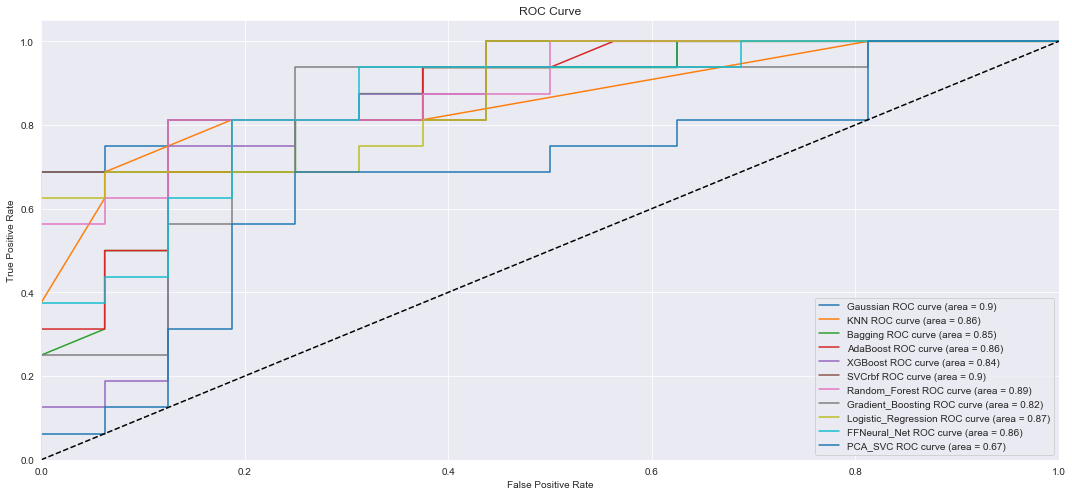

In [1544]:
# only probabilitic
models = list(zip([ensemble_models[x] for x in prob_models.Model], prob_models.Model))
plt.figure()

print("5-fold cross validation:\n")
clfs = []
for clf, model_label in models:
    scores = cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring=scoring, verbose=0)
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" %(scores.mean(), scores.std(), model_label))
    md = clf.fit(X_train_scaled, y_train)
    valid_soft_pred_matrix = pd.concat((valid_soft_pred_matrix, pd.DataFrame({model_label: md.predict_proba(X_test_scaled)[:,1]})), axis=1)
    # add to roc curve
    fpr, tpr, _ = roc_curve(y_test, md.predict_proba(X_test_scaled)[:,1])
    roc_auc = auc(fpr, tpr)
    
    print("ROC AUC: %0.2f" %roc_auc)
    plt.plot(fpr, tpr, label="{} ROC curve (area = {:.2})".format(model_label, roc_auc))
    
    clfs.append(md)
    print("Test Accuracy: %0.2f \n" % (metrics.accuracy_score(clf.predict(X_test_scaled), y_test)))
    
    # model on full data
    md = clf.fit(X,y)
    submission = md.predict(test_model)
    df = pd.DataFrame({"Patient ID": test["patient_id"],
                       "heart_disease_present": submission})
    train_hard_pred_matrix = pd.concat((train_hard_pred_matrix, pd.DataFrame({model_label: md.predict(X)})), axis=1)
    test_hard_pred_matrix = pd.concat((test_hard_pred_matrix, pd.DataFrame({model_label: submission})), axis=1)
    
    train_soft_pred_matrix = pd.concat((train_soft_pred_matrix, pd.DataFrame({model_label: md.predict_proba(X)[:,1]})),axis=1)
    test_soft_pred_matrix = pd.concat((test_soft_pred_matrix, pd.DataFrame({model_label: md.predict_proba(test_model)[:,1]})),axis=1)
    
    # output submission
    df.to_csv("{}.csv".format(model_label), header=True, index=False)
    
# plot
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

### Soft and Hard Voting Ensembles of Difference Sizes


2-Voting Models: 5-fold cross validation:

Train CV Accuracy: 0.81 (+/- 0.05) [2-VM-Ensemble Soft Voting]
Test Accuracy: 0.84
ROC AUC: 0.63
Train CV Accuracy: 0.84 (+/- 0.01) [2-VM-Ensemble Hard Voting]
Test Accuracy: 0.81

3-Voting Models: 5-fold cross validation:

Train CV Accuracy: 0.82 (+/- 0.05) [3-VM-Ensemble Soft Voting]
Test Accuracy: 0.84
ROC AUC: 0.81
Train CV Accuracy: 0.83 (+/- 0.03) [3-VM-Ensemble Hard Voting]
Test Accuracy: 0.84

5-Voting Models: 5-fold cross validation:

Train CV Accuracy: 0.83 (+/- 0.03) [5-VM-Ensemble Soft Voting]
Test Accuracy: 0.81
ROC AUC: 0.98
Train CV Accuracy: 0.80 (+/- 0.02) [5-VM-Ensemble Hard Voting]
Test Accuracy: 0.84

7-Voting Models: 5-fold cross validation:

Train CV Accuracy: 0.83 (+/- 0.03) [7-VM-Ensemble Soft Voting]
Test Accuracy: 0.81
ROC AUC: 0.98
Train CV Accuracy: 0.82 (+/- 0.04) [7-VM-Ensemble Hard Voting]
Test Accuracy: 0.84

10-Voting Models: 5-fold cross validation:

Train CV Accuracy: 0.82 (+/- 0.04) [10-VM-Ensemble Soft Vot

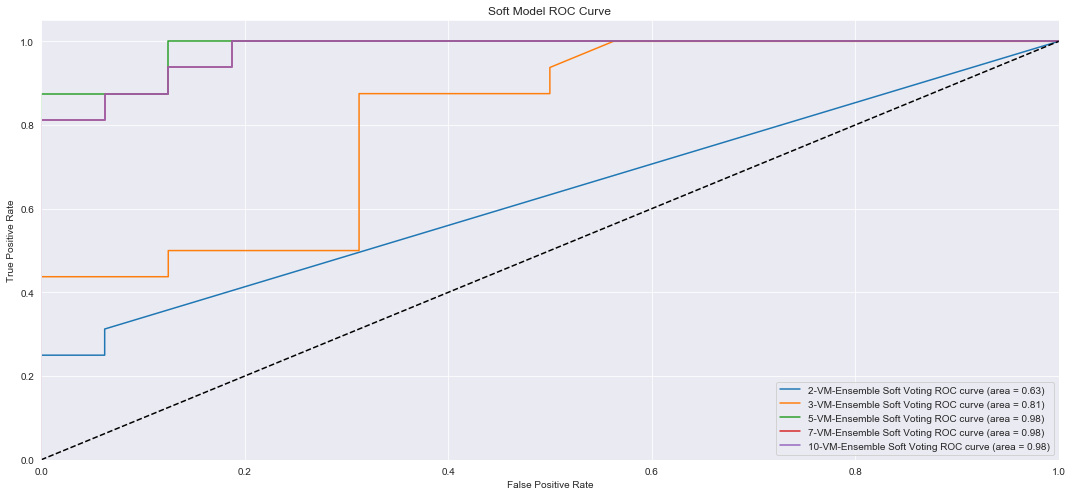

In [1545]:
plt.figure()
voters = {}
for x in [2,3,5,7,10]:
    ECH = EnsembleVoteClassifier([ensemble_models.get(key) for key in hard_models.Model[:x]], voting="hard")
    ECS = EnsembleVoteClassifier([ensemble_models.get(key) for key in prob_models.Model[:x]], voting="soft")
    print("\n{}-Voting Models: 5-fold cross validation:\n".format(x))
    for clf, model_label in zip([ECS, ECH],
                               ["{}-VM-Ensemble Soft Voting".format(x),
                               "{}-VM-Ensemble Hard Voting".format(x)]):
        scores = cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring="accuracy")
        print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" %(scores.mean(), scores.std(), model_label))
        md = clf.fit(X_train_scaled, y_train)
        clfs.append(md)
        
        Test_Score = metrics.accuracy_score(clf.predict(X_test_scaled), y_test)
        print("Test Accuracy: %0.2f" %Test_Score)
        CV_Score = scores.mean()
        STDev = scores.std()
        
        global results
        results = results.append({"Model": model_label,
                                 "Para": clf,
                                 "CV Mean": CV_Score,
                                 "Test_Score": Test_Score,
                                 "CV STDEV" : STDev}, ignore_index=True)
        voters[model_label] = clf
        
        # model on full data
        md = clf.fit(X, y)
        submission = md.predict(test_model)
        df = pd.DataFrame({"Patient Id": test["patient_id"],
                           "heart_disease_prediction": submission})
        df.to_csv("{}.csv".format(model_label), header=True, index=False)
        
        if clf is ECH:
            # Hard Correlation
            train_hard_pred_matrix = pd.concat((train_hard_pred_matrix, pd.DataFrame({model_label: md.predict(X)})), axis=1)
            test_hard_pred_matrix = pd.concat((test_hard_pred_matrix, pd.DataFrame({model_label: submission})), axis=1)
            
        elif clf is ECS:
            # Add to ROC Curve
            fpr, tpr, _ = roc_curve(y_test, md.predict_proba(X_test_scaled)[:,1])
            roc_auc = auc(fpr, tpr)
            print("ROC AUC: %0.2f" %roc_auc)
            plt.plot(fpr, tpr, label="{} ROC curve (area = {:.2})".format(model_label, roc_auc))
            
            # soft correlation
            train_soft_pred_matrix = pd.concat((train_soft_pred_matrix, pd.DataFrame({model_label: md.predict_proba(X)[:,1]})), axis=1)
            test_soft_pred_matrix = pd.concat((test_soft_pred_matrix, pd.DataFrame({model_label: md.predict_proba(test_model)[:,1]})),axis=1)
        
# plot
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Soft Model ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [1546]:
voters.get("10-VM-Ensemble Hard Voting")

EnsembleVoteClassifier(clfs=[GaussianNB(priors=None, var_smoothing=1e-09),
                             KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=8,
                                                  p=2, weights='uniform'),
                             BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                     criterion='gini',
                                                                                     max_depth=None,
                                                                                     max_features=None,
                                                                                     max

### Output Submission Matrix for Experimental Stacking

In [1551]:
# Add Validation Set
# Train prep

# Hard
train_hard_pred_matrix = train_hard_pred_matrix.set_index([df_train.index])
train_hard_pred_matrix = pd.concat([train_hard_pred_matrix, df_train["heart_disease_present"]],axis=1)
valid_hard_pred_matrix = valid_hard_pred_matrix.set_index([X_test.index])
valid_hard_pred_matrix = pd.concat([valid_hard_pred_matrix, df_train["heart_disease_present"][X_test.index]],axis=1)

# Soft
train_soft_pred_matrix = train_soft_pred_matrix.set_index([df_train.index])
train_soft_pred_matrix = pd.concat([train_soft_pred_matrix, df_train["heart_disease_present"]],axis=1)
valid_soft_pred_matrix = valid_soft_pred_matrix.set_index([X_test.index])
valid_soft_pred_matrix = pd.concat([valid_soft_pred_matrix, df_train["heart_disease_present"][X_test.index]], axis=1)

In [1552]:
# Test Prep

# Hard
test_hard_prep_matrix = test_hard_pred_matrix.set_index([test_model.index])
valid_hard_pred_matrix = valid_hard_pred_matrix.set_index([X_test.index])

# Soft
test_soft_prep_matrix = test_soft_pred_matrix.set_index([test_model.index])
valid_soft_pred_matrix = valid_soft_pred_matrix.set_index([X_test.index])

In [1555]:
# Output submission results
# Test
test_hard_pred_matrix.to_csv("C:\\Users\\joann\\OneDrive\\Desktop\\My Files\\Data Science\\Predicting Heart Disease\\test_hard_pred_matrix.csv")
test_soft_pred_matrix.to_csv("C:\\Users\\joann\\OneDrive\\Desktop\\My Files\\Data Science\\Predicting Heart Disease\\test_soft_pred_matrix.csv")
valid_soft_pred_matrix.to_csv("C:\\Users\\joann\\OneDrive\\Desktop\\My Files\\Data Science\\Predicting Heart Disease\\valid_soft_pred_matrix.csv")

# Train
train_hard_pred_matrix.to_csv("C:\\Users\\joann\\OneDrive\\Desktop\\My Files\\Data Science\\Predicting Heart Disease\\train_hard_pred_matrix.csv")
train_soft_pred_matrix.to_csv("C:\\Users\\joann\\OneDrive\\Desktop\\My Files\\Data Science\\Predicting Heart Disease\\train_soft_pred_matrix.csv")
valid_soft_pred_matrix.to_csv("C:\\Users\\joann\\OneDrive\\Desktop\\My Files\\Data Science\\Predicting Heart Disease\\valid_soft_pred_matrix.csv")

In [1556]:
train_hard_pred_matrix.head()

,StochasticGradientDescent,LinearSV,Gaussian,KNN,Bagging,AdaBoost,XGBoost,SVCrbf,Random_Forest,Gradient_Boosting,Logistic_Regression,FFNeural_Net,PCA_SVC,2-VM-Ensemble Hard Voting,3-VM-Ensemble Hard Voting,5-VM-Ensemble Hard Voting,7-VM-Ensemble Hard Voting,10-VM-Ensemble Hard Voting,heart_disease_present
72,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
104,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
116,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
64,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
169,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


### Experimenting with Classification Stacking

#### Binary Stacking

In [1610]:
# topmodel 
def topmodels(df, isin=results["Model"]):
    return [x for x in df if x in list(isin)+["heart_disease_present"]]

# subset models
train_hard_pred_matrix = train_hard_pred_matrix.loc[:, topmodels(df=train_hard_pred_matrix)]
test_hard_pred_matrix = test_hard_pred_matrix.loc[:, topmodels(df=test_hard_pred_matrix)]

In [1611]:
train_hard_pred_matrix.sample(5)

,StochasticGradientDescent,LinearSV,Gaussian,KNN,Bagging,AdaBoost,XGBoost,SVCrbf,Random_Forest,Gradient_Boosting,Logistic_Regression,FFNeural_Net,PCA_SVC,2-VM-Ensemble Hard Voting,3-VM-Ensemble Hard Voting,5-VM-Ensemble Hard Voting,7-VM-Ensemble Hard Voting,10-VM-Ensemble Hard Voting,heart_disease_present
107,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1.0
153,0,0,0,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,1.0
72,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
17,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0
40,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0.0


In [1601]:
results

,Model,Para,Test_Score,CV Mean,CV STDEV,Params
0,Gaussian,NaN,0.84375,0.815385,0.0448535,"GaussianNB(priors=None, var_smoothing=1e-09)"
1,KNN,NaN,0.81250,0.850000,0.0247771,"{'n_neighbors': 8, 'weights': 'uniform'}"
2,BESTXGBOOST,"{'eta': 0.05, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.75, 'min_child_weight': 1.5, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'seed': 23, 'lambda': 1.5, 'alpha': 0.6}",0.81250,0.944444,None,NaN
3,Bagging,NaN,0.78125,0.775641,0.119702,{'n_estimators': 176}
4,AdaBoost,NaN,0.78125,0.801282,0.0679306,"{'learning_rate': 0.1, 'n_estimators': 416}"
5,XGBoost,NaN,0.78125,0.802564,0.0390237,"{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 723}"
6,LGBM,"{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'max_depth': 12, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'bagging_freq': 5, 'max_bin': 300, 'lambda_l2': 1.5, 'is_unbalance': True}",0.78125,0.880952,None,NaN
7,SVCrbf,NaN,0.78125,0.850000,0.0361711,"{'svc__C': 6142, 'svc__gamma': 1e-07}"
8,StochasticGradientDescent,NaN,0.75000,0.793590,0.0506613,{'loss': 'hinge'}
9,Random_Forest,NaN,0.75000,0.833333,0.0298611,"{'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': 6, 'n_estimators': 300}"


In [1566]:
np.corrcoef(train_hard_pred_matrix["Random_Forest"].astype(float), train_hard_pred_matrix["heart_disease_present"].astype(float))[0,1]

0.772399462670879

In [1572]:
train_hard_pred_matrix["heart_disease_present"] = train_hard_pred_matrix["heart_disease_present"].astype(float)

In [1573]:
train_hard_pred_matrix.dtypes

StochasticGradientDescent     int32  
LinearSV                      int32  
Gaussian                      int32  
KNN                           int32  
Bagging                       int32  
AdaBoost                      int32  
XGBoost                       int32  
SVCrbf                        int32  
Random_Forest                 int32  
Gradient_Boosting             int32  
Logistic_Regression           int32  
FFNeural_Net                  int32  
PCA_SVC                       int32  
2-VM-Ensemble Hard Voting     int32  
3-VM-Ensemble Hard Voting     int32  
5-VM-Ensemble Hard Voting     int32  
7-VM-Ensemble Hard Voting     int32  
10-VM-Ensemble Hard Voting    int32  
heart_disease_present         float64
dtype: object

In [1590]:
# Accuracy Matrix
def accuracy_matrix(data):
    df = pd.DataFrame(columns = data.columns, index = data.columns)
    for row in data.columns:
        for col in data.columns:
            df.loc[row, col] = metrics.accuracy_score(data.loc[:, row], data.loc[:,col]).astype(float)
    for x in df.columns:
        df[x] = df[x].astype(float)
    return df
    
def acc_n_corr(df):
    # Train hard correlation, all models
    f, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", cbar_kws = {"label": "Correlation Coefficient"}, ax=ax[0])
    ax[0].set_title("Correlation Matrix")
    
    # Hard train accuracy matrix, all models
    sns.heatmap(accuracy_matrix(df), annot=True, cmap="coolwarm", cbar_kws={"label": "Accuracy Score"}, ax=ax[1])
    ax[1].set_title("Accuracy Score Matrix")

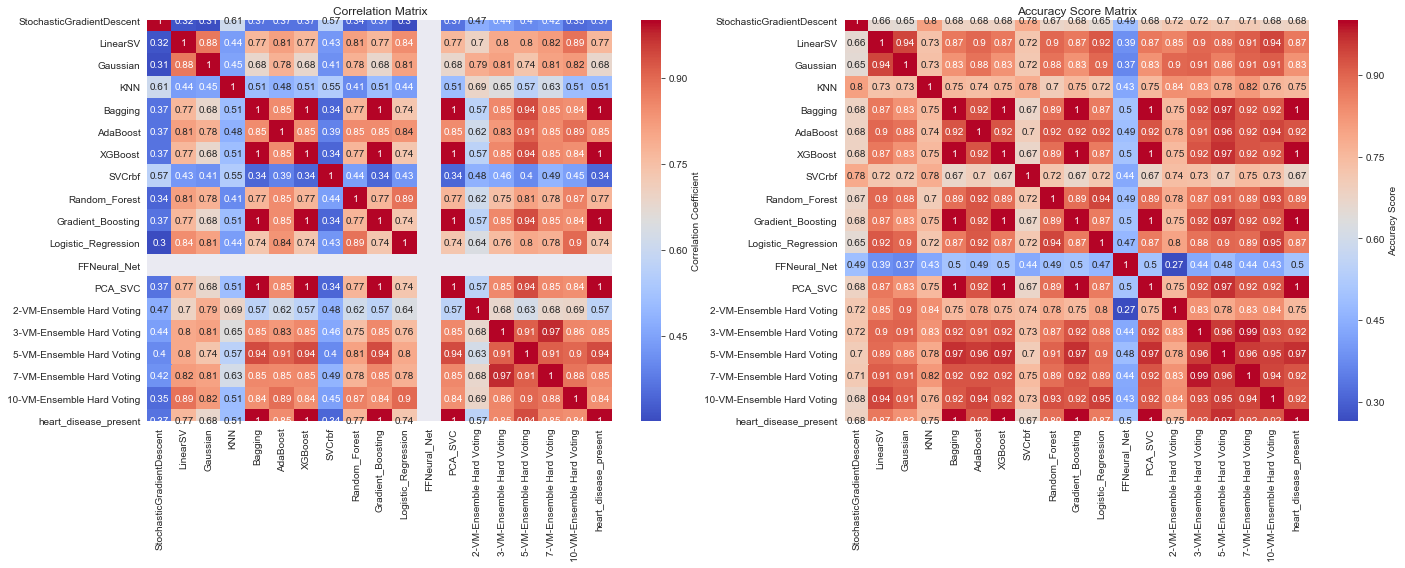

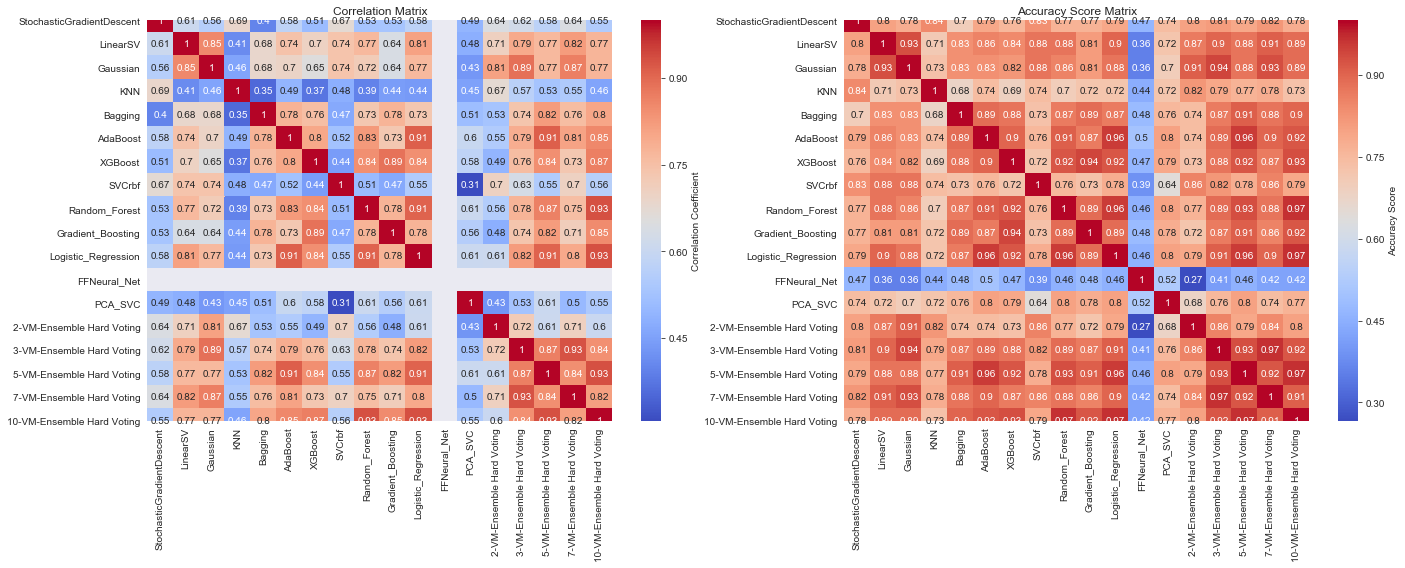

In [1593]:
acc_n_corr(df=train_hard_pred_matrix)
plt.show()
acc_n_corr(df=test_hard_pred_matrix)
plt.show()

In [ ]:
# smart binary value stacker
# find most accurate model and find the two least similar model and hardvote

def voter(df, test_model, results=results.loc[:, "Model"])

#### Probabilisitc Stacking

In [1594]:
def roc_AUC(data):
    df = pd.DataFrame(columns=data.columns, index=data.columns)
    for row in data.columns:
        for col in data.columns:
            df.loc[row,col] = metrics.roc_auc_score(data.loc[:,row],
                                                   data.loc[:,col]).astype(float)
    for x in df.columns:
        df[x] = df[x].astype(float)
    return df

def prob_n_corr(df):
    # Train Hard Correlation, All Models
    f, ax = plt.subplots(1, 2, figsize=[18, 5])
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", cbar_kws={"label": "Correlation Coefficient"}, ax=ax[0])
    ax[0].set_title("Correlation Matrix")
    
    # Hard Train Accuracy Matrix, All Model
    sns.heatmap(roc_AUC(df), annot=True, cmap="coolwarm", cbar_kws={"label": "ROC_AUC Score"}, ax=ax[1])
    ax[1].set_title("ROC AUC Score Matrix")

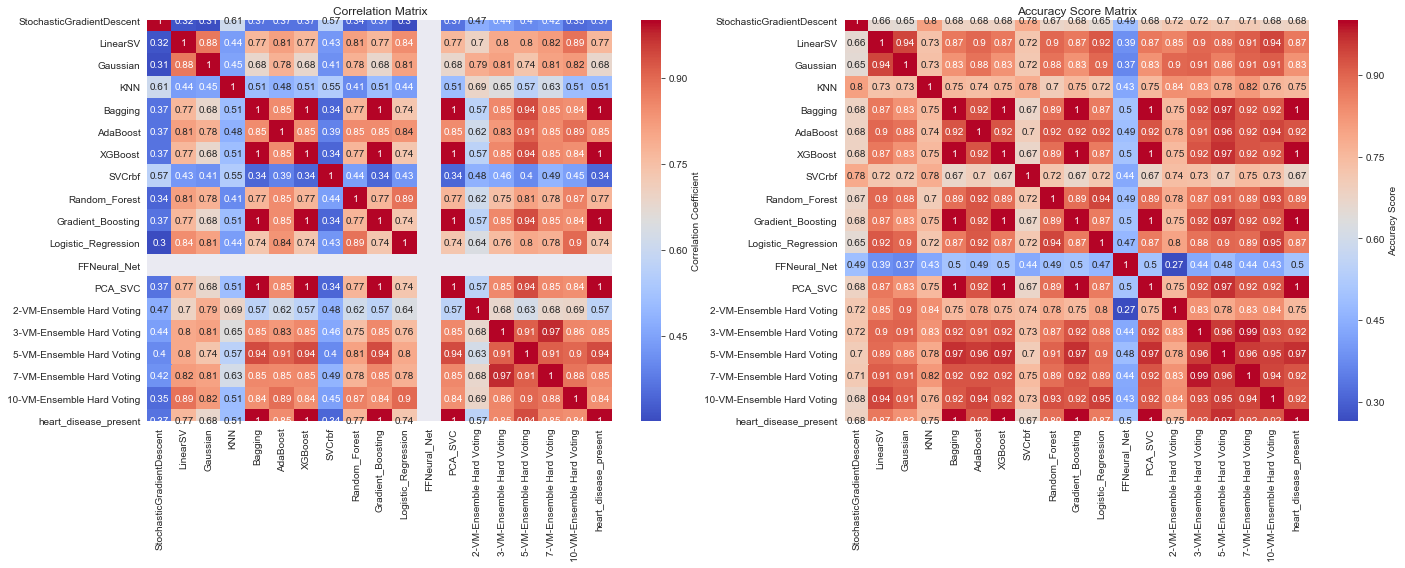

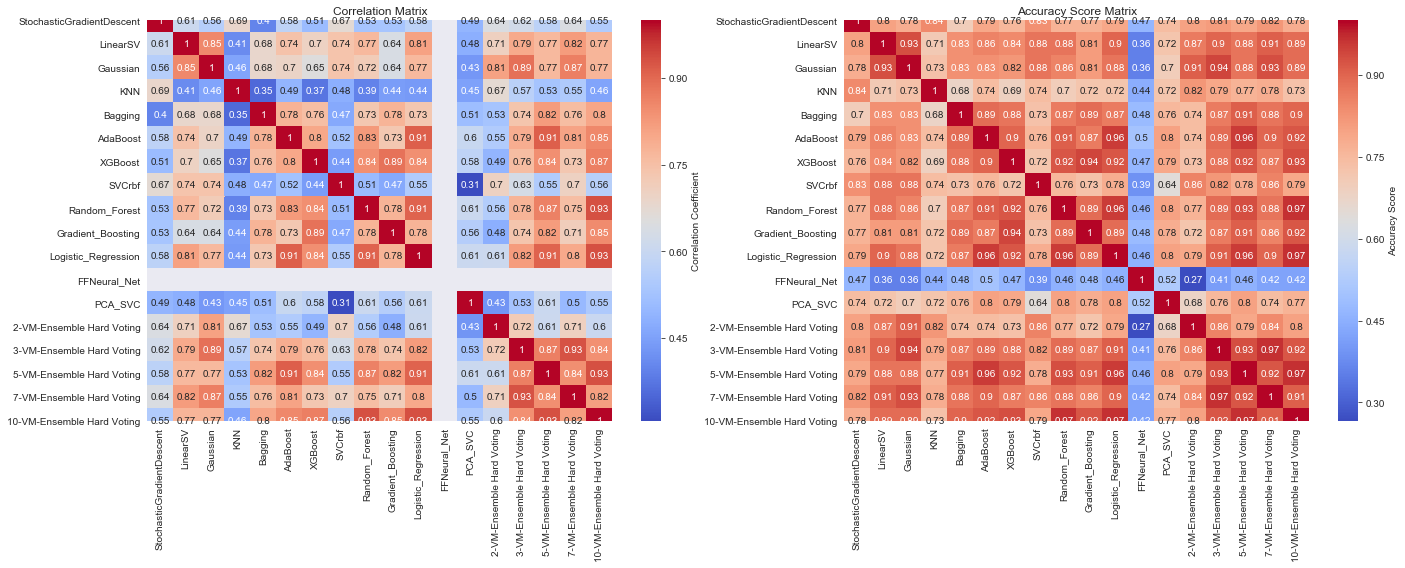

In [1595]:
acc_n_corr(df=train_hard_pred_matrix)
plt.show()
acc_n_corr(df=test_hard_pred_matrix)
plt.show()

#### Stacking Probabilities Output: Explore Stacking

I want to combine models based on the accuracy score matrix

In [1612]:
# set cutoff threshold for lower and upper bounds
cutoff_lo = 0.8
cutoff_hi = 0.2

# gather descriptive statistics for stacking
def manual_stack(data):
    df = pd.DataFrame()
    df["max"] = data.max(axis=1)
    df["min"] = data.min(axis=1)
    df["mean"] = data.mean(axis=1)
    df["median"] = data.median(axis=1)
    return df

In [1613]:
test_soft_stack = manual_stack(data=test_soft_pred_matrix)

In [1614]:
# simple probabilities stack
train_soft_pred_matrix = train_soft_pred_matrix.loc[:, topmodels(df=train_soft_pred_matrix)]
test_soft_pred_matrix = test_soft_pred_matrix.loc[:, topmodels(df=test_soft_pred_matrix)]

In [1629]:
stacks_soft = manual_stack(test_soft_pred_matrix)

In [1658]:
stacks_hard = manual_stack(train_soft_pred_matrix)

In [1633]:
#stacks.to_csv("C:\\Users\\joann\\OneDrive\\Desktop\\My Files\\Data Science\\Predicting Heart Disease\\train_stacked_result.csv")

In [1636]:
train_soft_pred_matrix["stacked_average"] = stacks_soft["mean"]

In [1659]:
train_hard_pred_matrix["stacked_average"] = stacks_hard["mean"]

In [1645]:
stacked_label = []
for i in train_soft_pred_matrix["stacked_average"]:
    if (i < 0.5):
        stacked_label.append("0")
    elif (i >= 0.5):
        stacked_label.append("1")
    else:
        stacked_label.append("Error")

In [1647]:
train_soft_pred_matrix["stacked_average_label"] = stacked_label

In [1661]:
stacked_label = []
for i in train_hard_pred_matrix["stacked_average"]:
    if (i < 0.5):
        stacked_label.append("0")
    elif (i >= 0.5):
        stacked_label.append("1")
    else:
        stacked_label.append("Error")

In [1655]:
pd.crosstab(train_soft_pred_matrix["stacked_average_label"], train_soft_pred_matrix["heart_disease_present"])

heart_disease_present,0,1
stacked_average_label,,
0,77,0
1,2,79


In [1670]:
# Simple Mode Blend
modeblend = train_hard_pred_matrix.drop(["heart_disease_present","stacked_average"] ,axis=1)
modeblend

,StochasticGradientDescent,LinearSV,Gaussian,KNN,Bagging,AdaBoost,XGBoost,SVCrbf,Random_Forest,Gradient_Boosting,Logistic_Regression,FFNeural_Net,PCA_SVC,2-VM-Ensemble Hard Voting,3-VM-Ensemble Hard Voting,5-VM-Ensemble Hard Voting,7-VM-Ensemble Hard Voting,10-VM-Ensemble Hard Voting
72,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
104,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
116,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
64,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
169,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
126,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
22,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
146,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0
4,1,0,1,1,0,1,0,1,1,0,1,1,0,1,1,1,1,1
33,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [1672]:
train_hard_pred_matrix["Mode"] = modeblend.mode(axis=1)[0]

In [1673]:
train_hard_pred_matrix

,StochasticGradientDescent,LinearSV,Gaussian,KNN,Bagging,AdaBoost,XGBoost,SVCrbf,Random_Forest,Gradient_Boosting,Logistic_Regression,FFNeural_Net,PCA_SVC,2-VM-Ensemble Hard Voting,3-VM-Ensemble Hard Voting,5-VM-Ensemble Hard Voting,7-VM-Ensemble Hard Voting,10-VM-Ensemble Hard Voting,heart_disease_present,stacked_average,Mode
72,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.230122,0.0
104,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0.0,0.363458,0.0
116,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0.0,0.313121,0.0
64,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.208453,0.0
169,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0.0,0.326923,0.0
126,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0.0,0.322621,0.0
22,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0.0,0.285741,0.0
146,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0.0,0.335328,0.0
4,1,0,1,1,0,1,0,1,1,0,1,1,0,1,1,1,1,1,0.0,0.546202,1.0
33,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.318223,0.0


In [1675]:
pd.crosstab(train_hard_pred_matrix["heart_disease_present"], train_hard_pred_matrix["Mode"])

Mode,0.0,1.0
heart_disease_present,,
0.0,78,1
1.0,7,72
